In [28]:
import warnings
import pandas as pd
import numpy as np
import os
from concurrent.futures import ThreadPoolExecutor
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [30]:
warnings.simplefilter("ignore")

In [31]:
train = pd.read_csv('child-mind-institute-problematic-internet-use/train.csv')

In [32]:
train.head()

id Basic_Demos-Enroll_Season  Basic_Demos-Age  Basic_Demos-Sex  \
0  00008ff9                      Fall                5                0   
1  000fd460                    Summer                9                0   
2  00105258                    Summer               10                1   
3  00115b9f                    Winter                9                0   
4  0016bb22                    Spring               18                1   

  CGAS-Season  CGAS-CGAS_Score Physical-Season  Physical-BMI  Physical-Height  \
0      Winter             51.0            Fall     16.877316             46.0   
1         NaN              NaN            Fall     14.035590             48.0   
2        Fall             71.0            Fall     16.648696             56.5   
3        Fall             71.0          Summer     18.292347             56.0   
4      Summer              NaN             NaN           NaN              NaN   

   Physical-Weight  ...  PCIAT-PCIAT_18  PCIAT-PCIAT_19  PCIAT-PCIAT_20  \
0             50.8  ...             4.0             2.0             4.0   
1             46.0  ...             0.0             0.0             0.0   
2             75.6  ...             2.0             1.0             1.0   
3             81.6  ...             3.0             4.0             1.0   
4              NaN  ...             NaN             NaN             NaN   

   PCIAT-PCIAT_Total SDS-Season  SDS-SDS_Total_Raw  SDS-SDS_Total_T  \
0               55.0        NaN                NaN              NaN   
1                0.0       Fall               46.0             64.0   
2               28.0       Fall               38.0             54.0   
3               44.0     Summer               31.0             45.0   
4                NaN        NaN                NaN              NaN   

   PreInt_EduHx-Season PreInt_EduHx-computerinternet_hoursday  sii  
0                 Fall                                    3.0  2.0  
1               Summer                                    0.0  0.0  
2               Summer                                    2.0  0.0  
3               Winter                                    0.0  1.0  
4                  NaN                                    NaN  NaN  

[5 rows x 82 columns]

In [33]:
train.info()
#Findings: The dataset has considerable null values, even the target variable has almost 1/3 null values.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3960 entries, 0 to 3959
Data columns (total 82 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   id                                      3960 non-null   object 
 1   Basic_Demos-Enroll_Season               3960 non-null   object 
 2   Basic_Demos-Age                         3960 non-null   int64  
 3   Basic_Demos-Sex                         3960 non-null   int64  
 4   CGAS-Season                             2555 non-null   object 
 5   CGAS-CGAS_Score                         2421 non-null   float64
 6   Physical-Season                         3310 non-null   object 
 7   Physical-BMI                            3022 non-null   float64
 8   Physical-Height                         3027 non-null   float64
 9   Physical-Weight                         3076 non-null   float64
 10  Physical-Waist_Circumference            898 non-null    floa

In [34]:
#Target variable has float type. Lets convert the data type to object.

if train['sii'].dtype != 'object':
    train['sii'] = train['sii'].astype('object')
    

data_type = train['sii'].dtype
print(data_type)

object


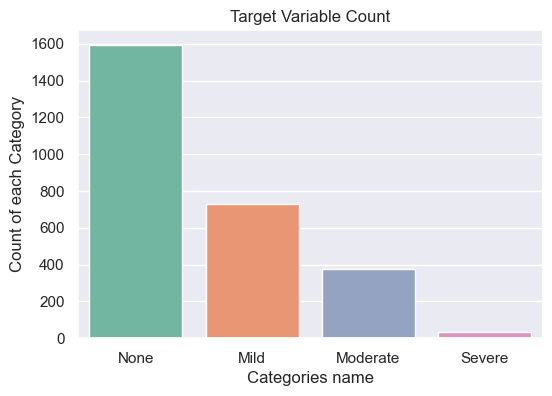

In [35]:
#Check the distribution of the target variable.
plt.figure(figsize=(6,4))
temp_col = train['sii']

temp_col = temp_col.replace({0.0 : 'None', 1.0 : 'Mild', 2.0 : 'Moderate', 3.0 : 'Severe'})
sii_cat_count = temp_col.value_counts()

sns.set(font_scale=1.0)
sns.barplot(x=sii_cat_count.index, y=sii_cat_count, palette='Set2')
plt.title('Target Variable Count')
plt.xlabel('Categories name')
plt.ylabel('Count of each Category')
plt.show()
# Findings : The data is highly imbalnce as the count of None is comparitvely high than the other categories.

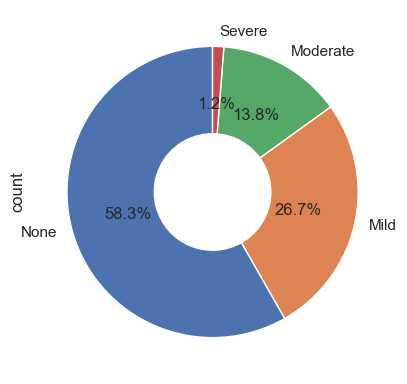

In [36]:

plt.figure(figsize=(6,4))
temp_col = train['sii']

temp_col = temp_col.replace({0.0 : 'None', 1.0 : 'Mild', 2.0 : 'Moderate', 3.0 : 'Severe'})
sii_cat_count = temp_col.value_counts()
sii_cat_count.plot(kind='pie',  autopct='%1.1f%%', startangle=90, wedgeprops={'width': 0.6})
ax.set_title('Target Variable')
ax.set_ylabel('Sii')
ax.axis('equal')
# Adjust layout to ensure the chart is centered but it is not working!
plt.subplots_adjust(left=0.2, right=0.8, top=0.8, bottom=0.2)
plt.tight_layout()
plt.show()

#Findings: The genders of the participants is mostly male.

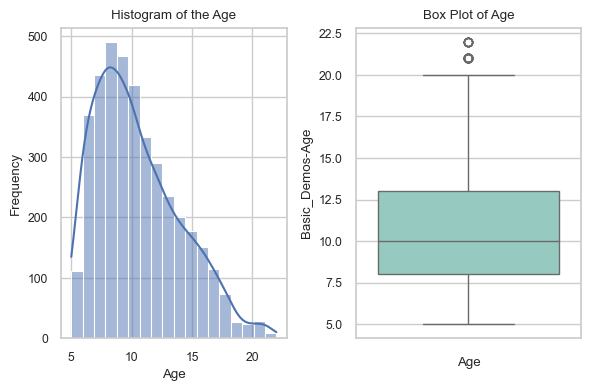

In [37]:
# The distribution of age coulmn
temp_col = train['Basic_Demos-Age']
age_dist = temp_col.value_counts()
sns.set(font_scale=0.8)
sns.set_style('whitegrid')
plt.figure(figsize=(6,4))

plt.subplot(1,2,1)
sns.histplot(x=temp_col, kde='True', palette='Set2', bins=18)
plt.title('Histogram of the Age')
plt.xlabel('Age')
plt.ylabel('Frequency')

plt.subplot(1,2,2)
sns.boxplot(temp_col, palette='Set3')
plt.title('Box Plot of Age')
plt.xlabel('Age')

plt.tight_layout()
plt.show()
# Findings: Age is mostly distributed between 8 to 13 years. The fature has outliers that needed to be dropped.

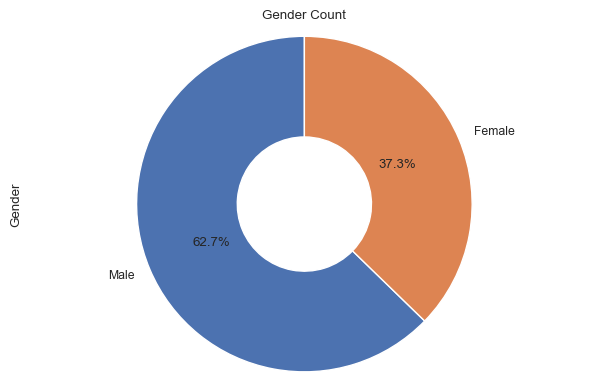

Basic_Demos-Sex
0    0.627273
1    0.372727
Name: proportion, dtype: float64

In [38]:
# Proportion of sex column
fig, ax = plt.subplots(figsize=(6,4))
temp_col = train['Basic_Demos-Sex']
sex_cat_count = temp_col.value_counts(normalize=True)
sex_cat_count.plot(kind='pie', labels=['Male', 'Female'], autopct='%1.1f%%', startangle=90, wedgeprops={'width': 0.6})
ax.set_title('Gender Count')
ax.set_ylabel('Gender')
ax.axis('equal')
# Adjust layout to ensure the chart is centered but it is not working!
plt.subplots_adjust(left=0.2, right=0.8, top=0.8, bottom=0.2)
plt.tight_layout()
plt.show()
sex_cat_count
#Findings: The genders of the participants is mostly male.

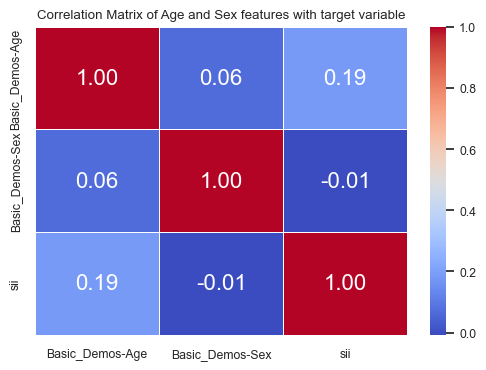

In [39]:
# Now analyze the relationship of features with target variable.
# Age and Sex features vs target variable
df_temp = None

df_temp = train[['Basic_Demos-Age', 'Basic_Demos-Sex', 'sii']]
label_encoder = LabelEncoder()
cat = df_temp.select_dtypes('object').columns.to_list()
for col in cat:
    df_temp[col] = label_encoder.fit_transform(df_temp[col])
    
plt.figure(figsize=(6, 4))
sns.heatmap(df_temp.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, annot_kws={"size": 16})
plt.title('Correlation Matrix of Age and Sex features with target variable')
plt.show()
#Findings: Age has a considerable correlation with the target variable.

In [40]:
# This is categrical feature so it should be object. Change its dtype to object.
if train['BIA-BIA_Activity_Level_num'].dtype != 'object':
    train['BIA-BIA_Activity_Level_num'] = train['BIA-BIA_Activity_Level_num'].astype('object')
    

data_type = train['BIA-BIA_Activity_Level_num'].dtype
print(data_type)

object


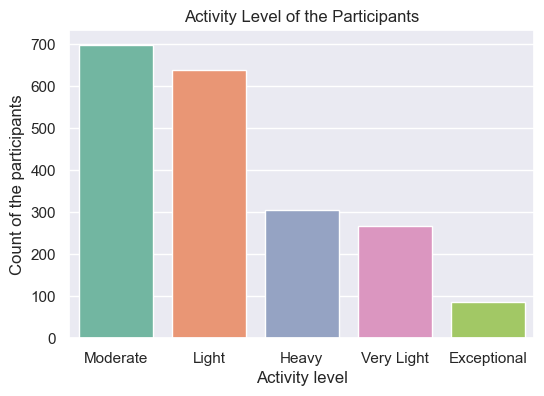

In [41]:
# Lets analyse the activit level of the participants.
sns.set(font_scale=1.0)
plt.figure(figsize=(6,4))
temp_col = train['BIA-BIA_Activity_Level_num']
#"1=Very Light, 2=Light, 3=Moderate, 4=Heavy, 5=Exceptional"
temp_col = temp_col.replace({1 : 'Very Light', 2 : 'Light', 3 : 'Moderate', 4 : 'Heavy', 5 : 'Exceptional'})
bia_cat_count = temp_col.value_counts()
sns.barplot(x=bia_cat_count.index, y=bia_cat_count, palette='Set2')
plt.title('Activity Level of the Participants')
plt.xlabel('Activity level')
plt.ylabel('Count of the participants')
plt.show()
# Findings: The activity level of the participants is mostly moderate and light. There are very few that has an
# exceptional activity level.

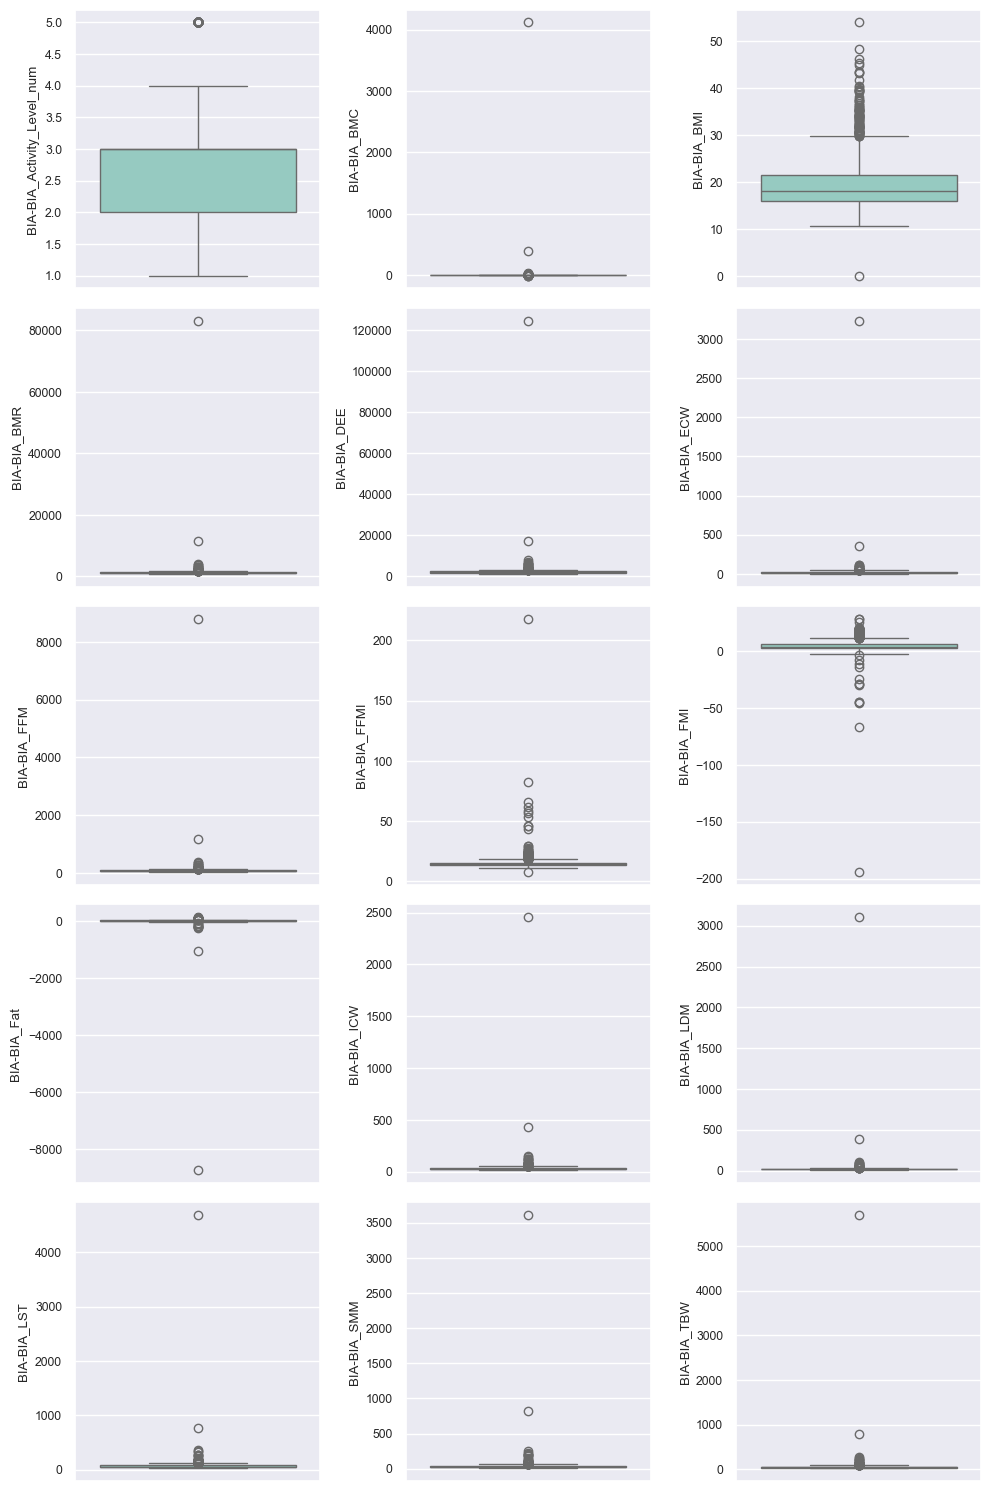

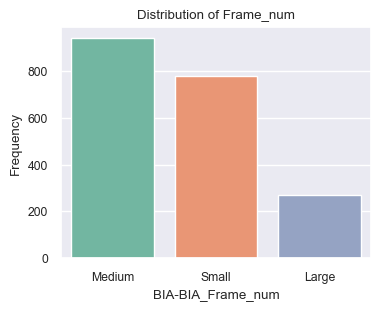

In [68]:
# Analyse all the BIA features of the participants.
df_temp = None
temp_col = None
df_temp = train.loc[:, train.columns.str.contains('BIA')]
df_temp = df_temp.drop(['BIA-Season', 'BIA-BIA_Frame_num'], axis=1)

n_features = len(df_temp.columns)
n_cols = 3
n_rows = (n_features // n_cols) + (n_features % n_cols != 0)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 3 * n_rows))
axes = axes.flatten()  
sns.set(font_scale=0.8)
for i, feature in enumerate(df_temp.columns):
    sns.boxplot(df_temp[feature], ax=axes[i], palette='Set3')  

for j in range(i + 1, len(axes)):
    axes[j].axis('off')  # Hide the extra subplots

plt.tight_layout()
plt.show()


#FINDINGS: Almost all the features has outliers that needed to be dropped.
temp_col = None
plt.figure(figsize=(4,3))
temp_col = train['BIA-BIA_Frame_num']
#1=Small, 2=Medium, 3=Large"
temp_col = temp_col.replace({1 : 'Small', 2 : 'Medium', 3 : 'Large'})
bia_cat_count = temp_col.value_counts()
sns.barplot(x=bia_cat_count.index, y=bia_cat_count, palette='Set2')
plt.title('Distribution of Frame_num')
plt.xlabel('BIA-BIA_Frame_num')
plt.ylabel('Frequency')
plt.show()
#Findings: Almost every feature has outlier that needed to be dropped.The plots are the indicative of anamolies
#as well.


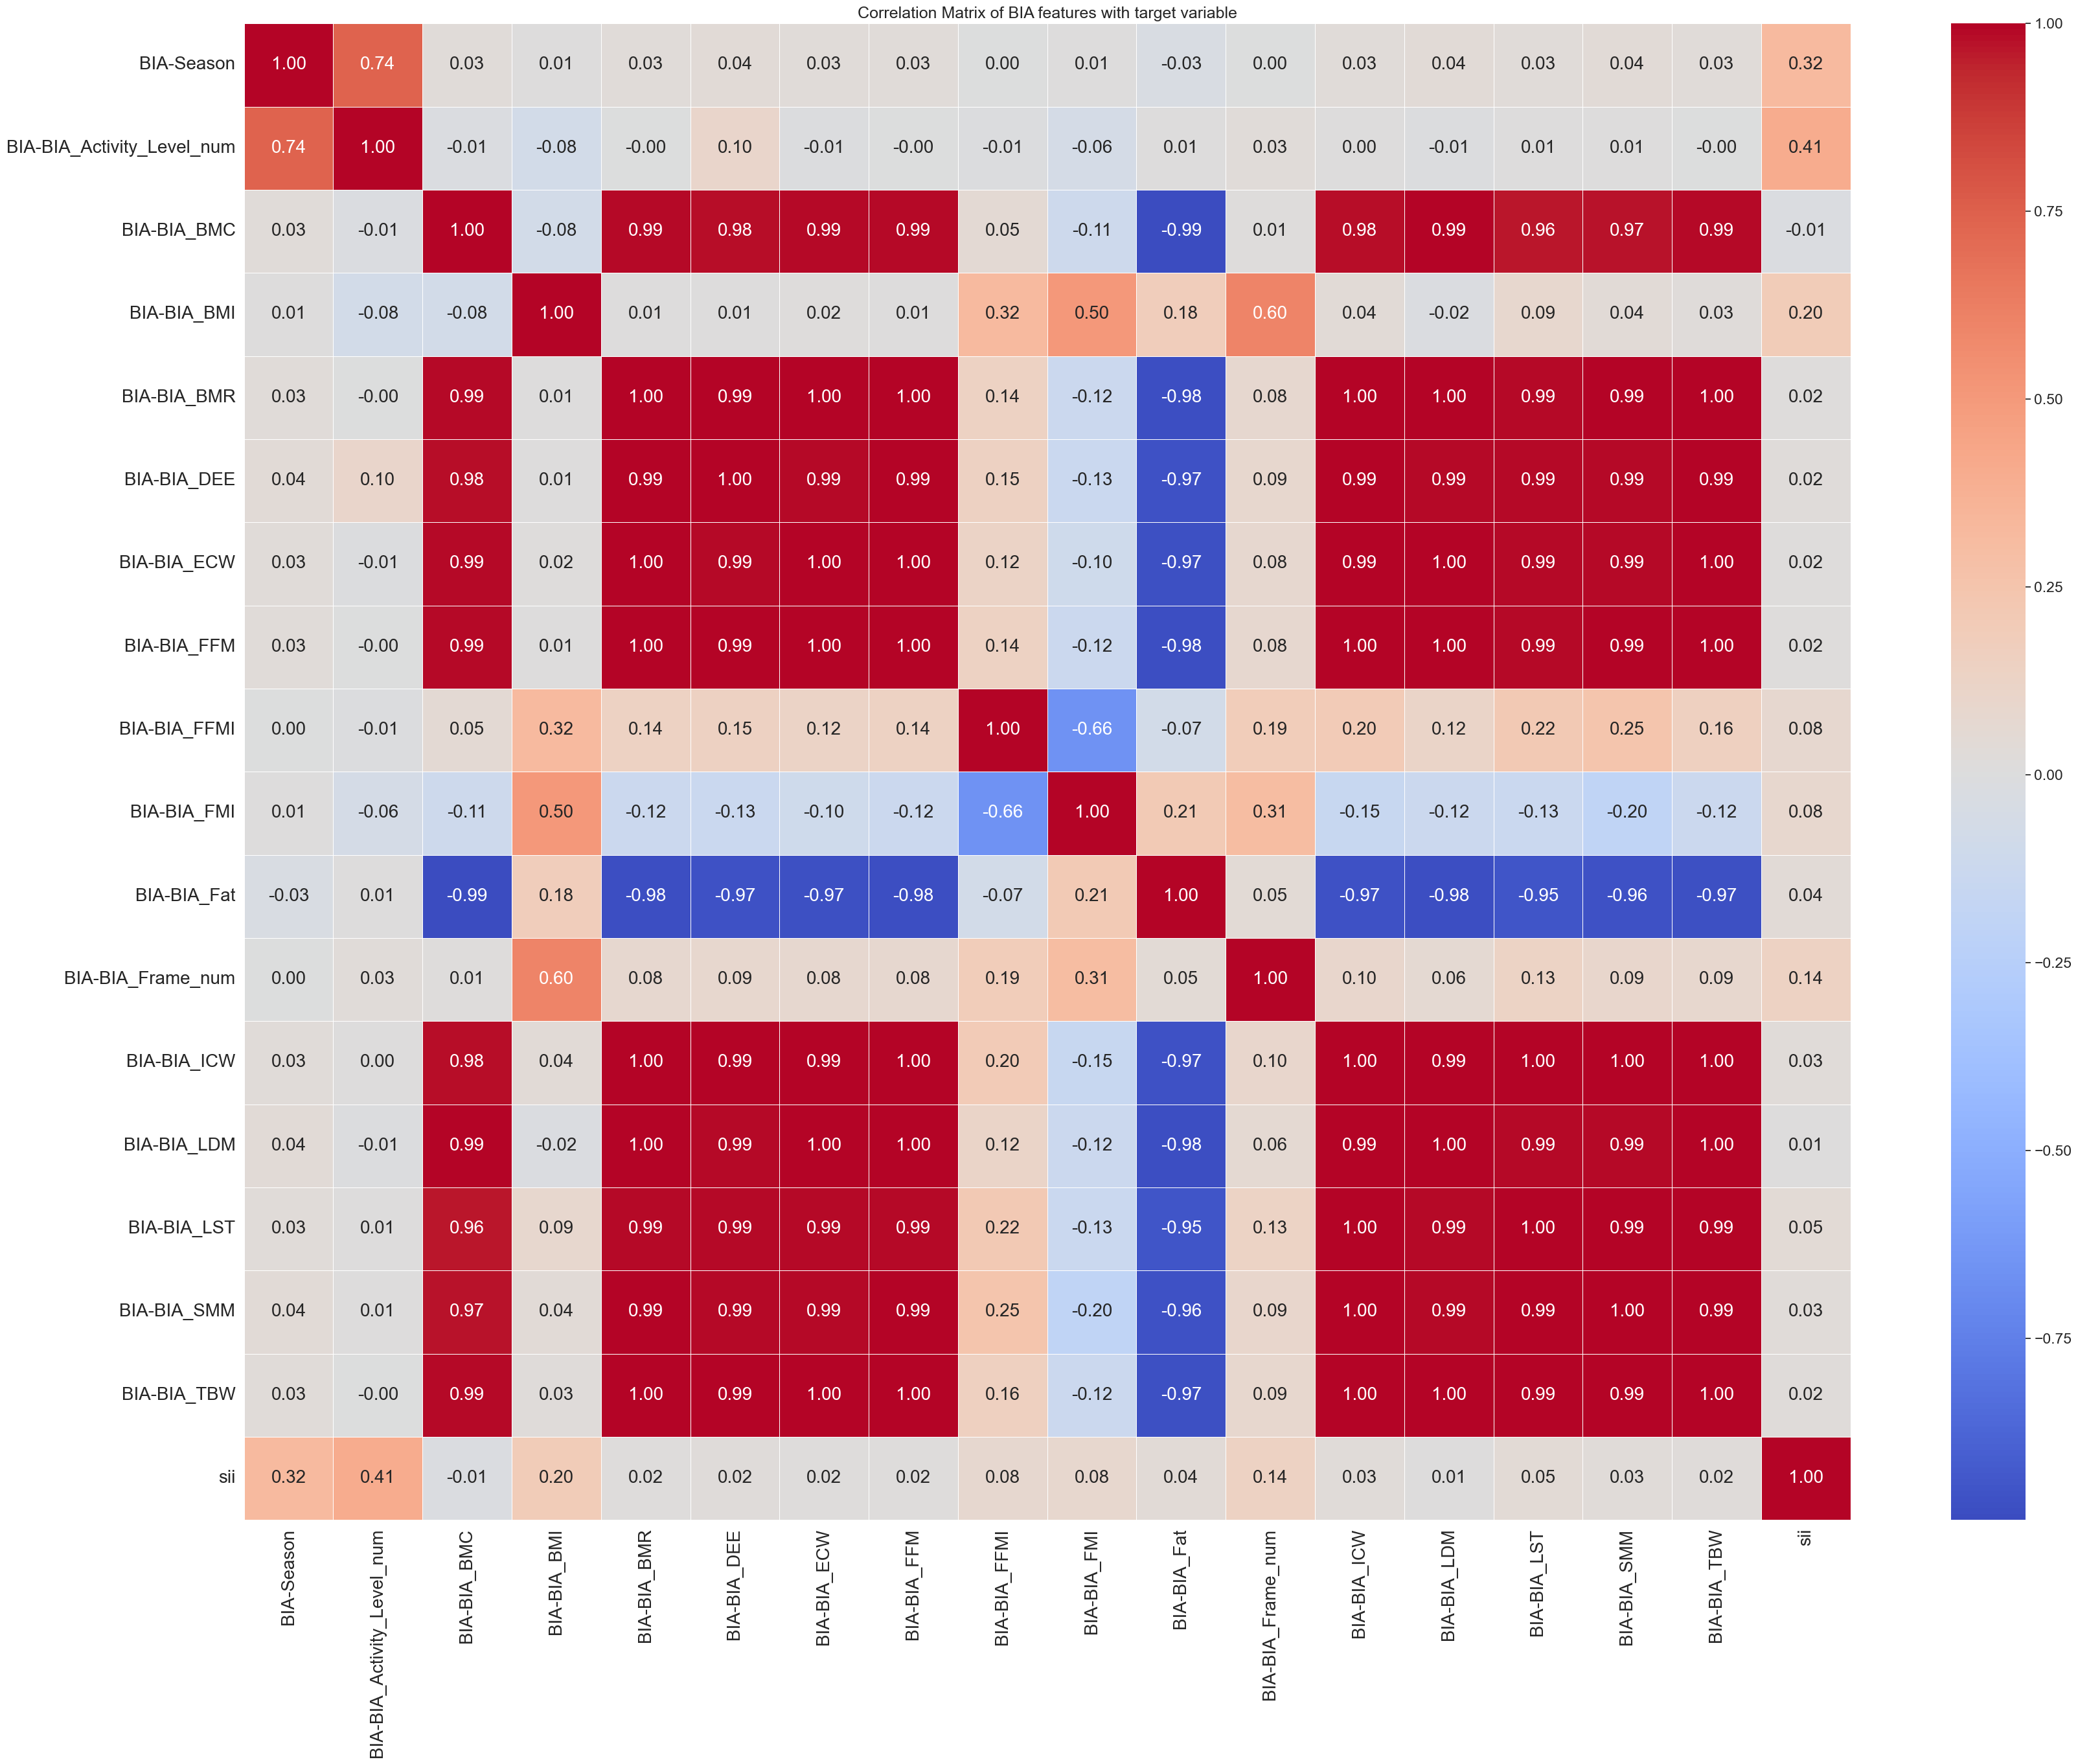

In [43]:
# Now analyze the correlation of features with target variable.
# BIA columns vs target variable
df_temp = None
df_temp = train.loc[:, train.columns.str.contains('BIA')]
df_temp['sii'] = train['sii']
label_encoder = LabelEncoder()
cat = df_temp.select_dtypes('object').columns.to_list()
for col in cat:
    df_temp[col] = label_encoder.fit_transform(df_temp[col])
    
plt.figure(figsize=(40, 30))
sns.set(font_scale=1.5)
ax = sns.heatmap(df_temp.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, annot_kws={"size": 20})
ax.set_xticklabels(ax.get_xticklabels(), fontsize=20)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=20)

plt.title('Correlation Matrix of BIA features with target variable')
plt.show()
#Findings: The target variable does not display strong correlation with BIA features, although, BIA features
# displays a stong correlation with each other. A lot of BMI feature has correlation of 1 with each other.

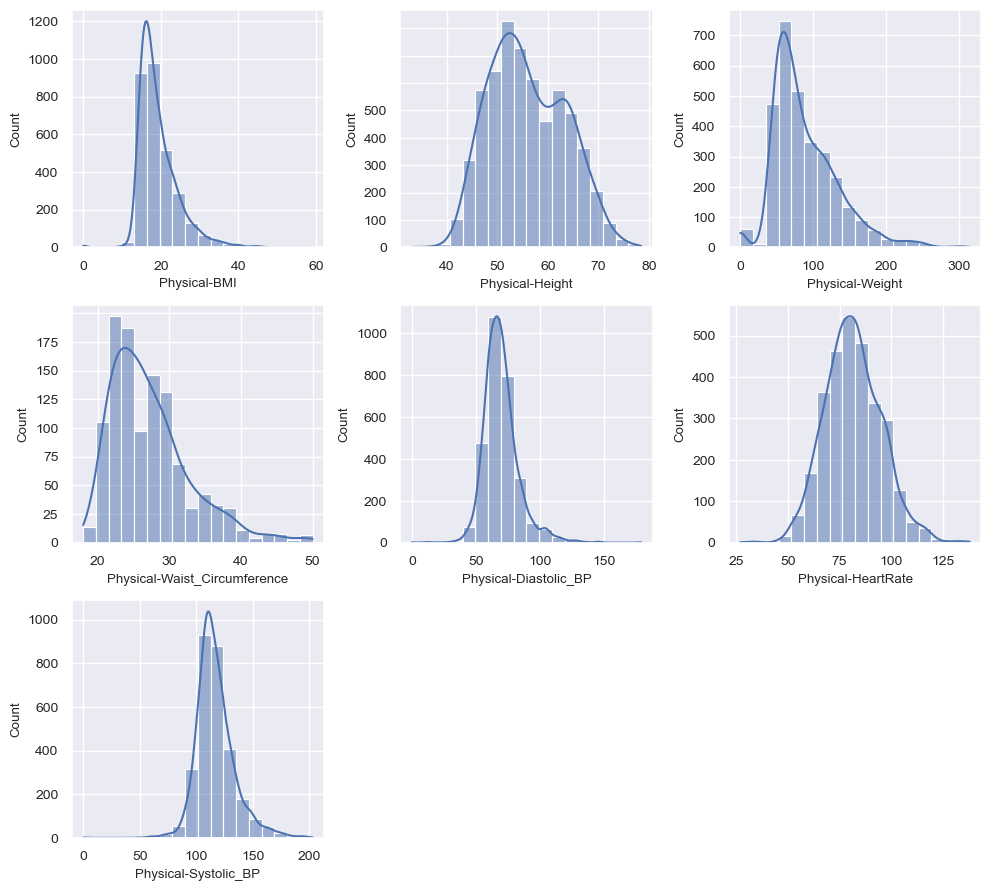

In [65]:
# Distribution of all Physical features..........
df_temp = None
temp_col = None
df_temp = train.loc[:, train.columns.str.contains('Physical')]
df_temp = df_temp.drop('Physical-Season', axis=1)

n_features = len(df_temp.columns)
n_cols = 3
n_rows = (n_features // n_cols) + (n_features % n_cols != 0)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 3 * n_rows))
axes = axes.flatten() 

for i, feature in enumerate(df_temp.columns):
    sns.set(font_scale=0.8)
    ax = sns.histplot(x=df_temp[feature], ax=axes[i], kde='True', palette='Set2', bins=18)  
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=10)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)

for j in range(i + 1, len(axes)):
    axes[j].axis('off')  # Hide the extra subplots

plt.tight_layout()
plt.show()
#Findings: Except physical hieght, rest of the features display normal distribution.

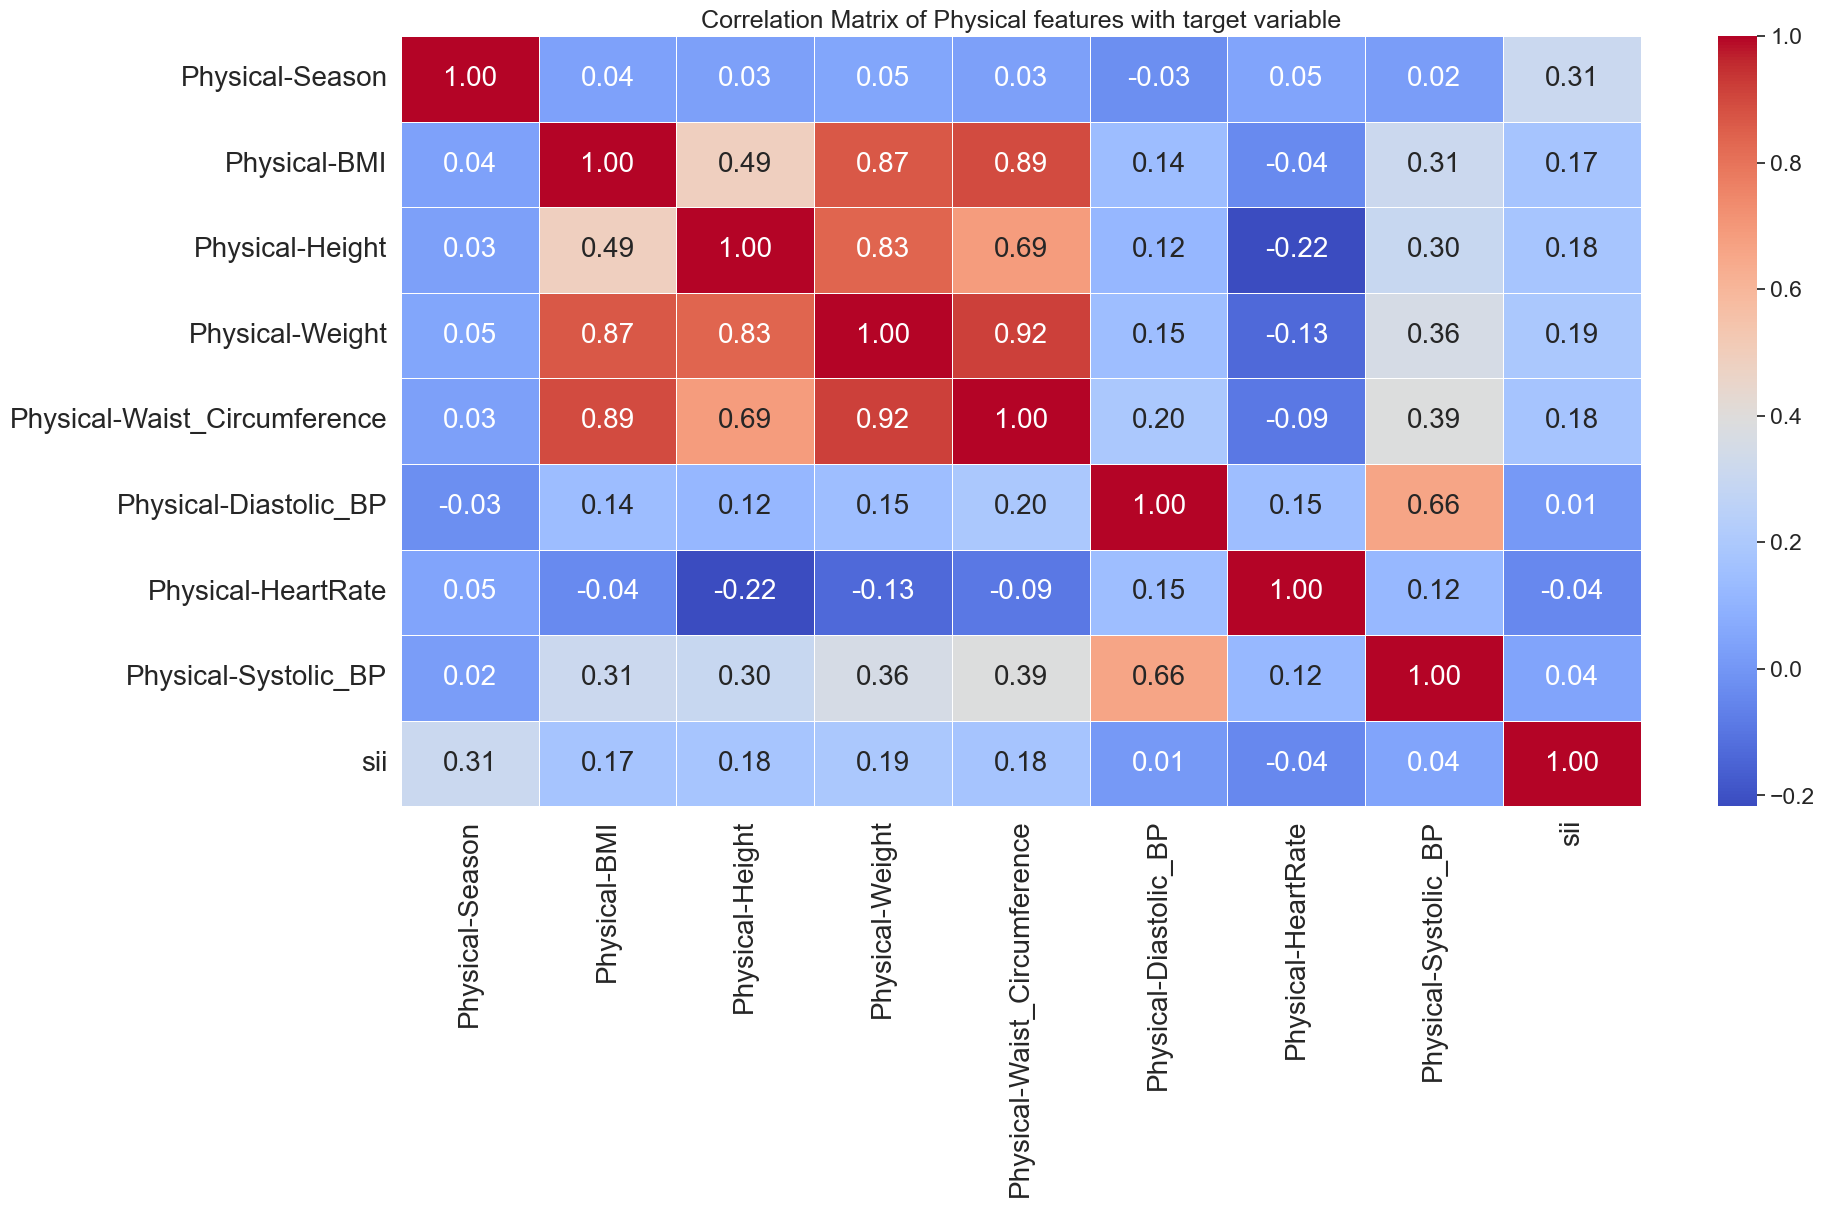

In [45]:

# Correlation of Physical features vs target variable
df_temp = None
df_temp = train.loc[:, train.columns.str.contains('Physical')]
df_temp['sii'] = train['sii']
label_encoder = LabelEncoder()
cat = df_temp.select_dtypes('object').columns.to_list()
for col in cat:
    df_temp[col] = label_encoder.fit_transform(df_temp[col])
    
plt.figure(figsize=(20, 10))
sns.set(font_scale=1.5)
ax = sns.heatmap(df_temp.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, annot_kws={"size": 20})
ax.set_xticklabels(ax.get_xticklabels(), fontsize=20)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=20)

plt.title('Correlation Matrix of Physical features with target variable')
plt.show()
# Findings: Again features are strongly related to each other than the target variable.

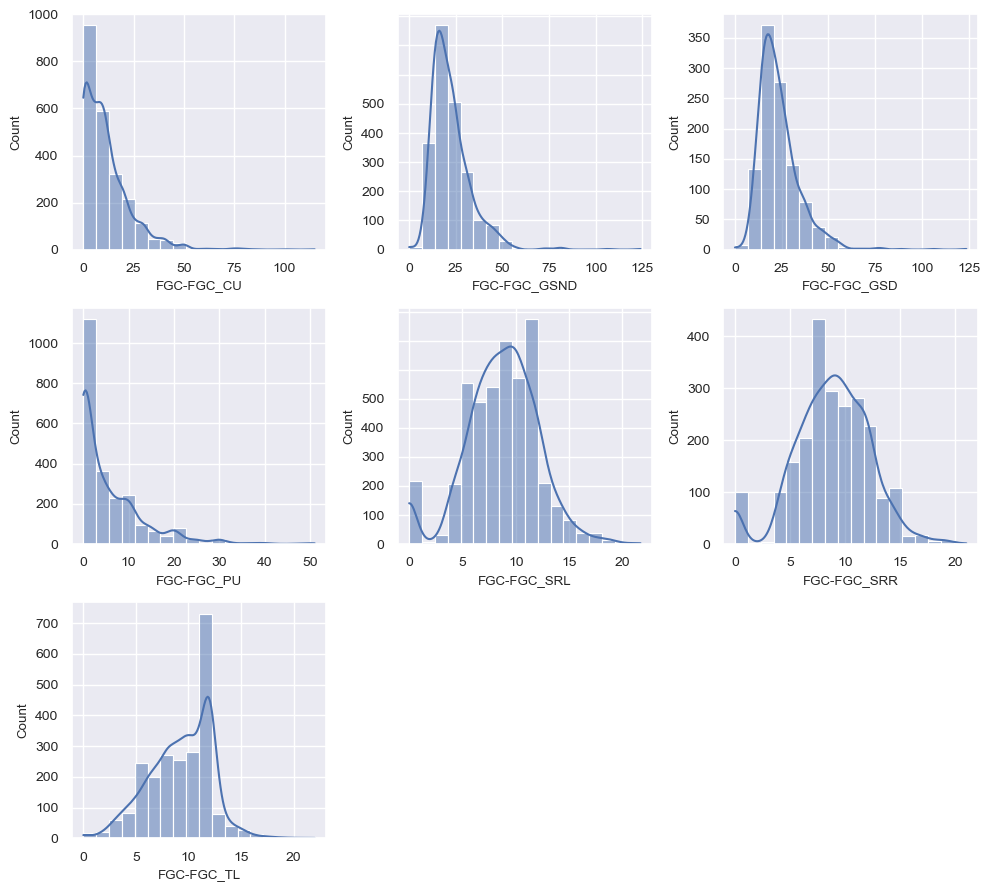

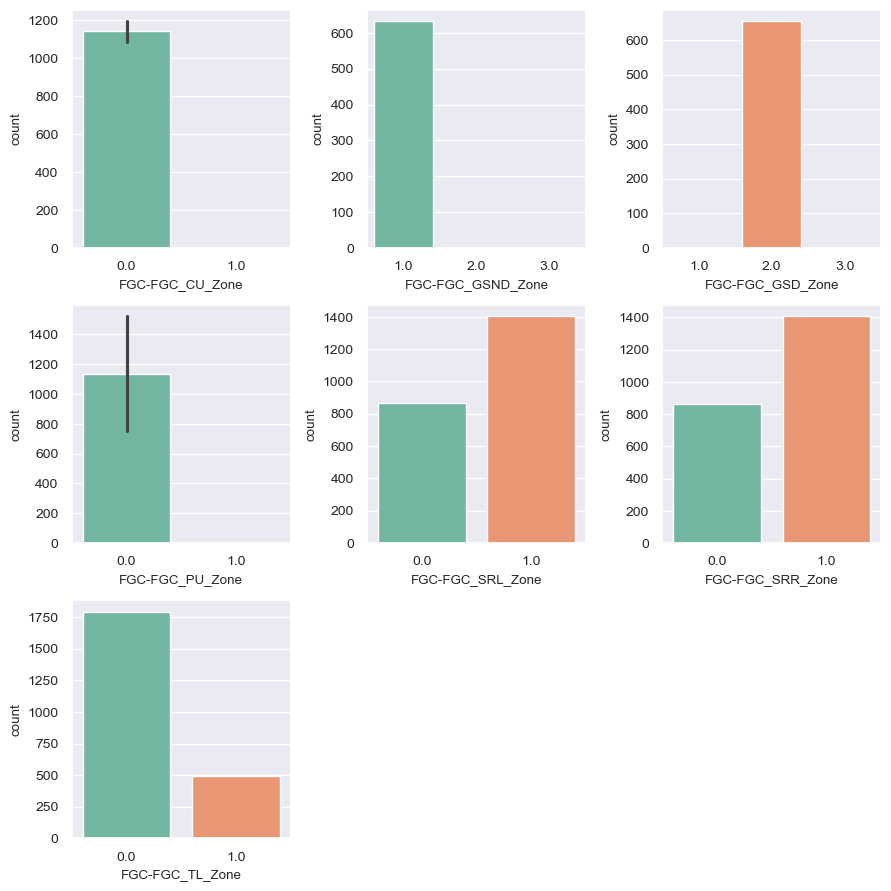

In [64]:
# Distribution and count plot of all FGC features..............
df_temp = None
temp_col = None
df_temp = train.loc[:, train.columns.str.contains('FGC')]
df_obj = df_temp.loc[:, df_temp.columns.str.contains('Zone')]                   
df_temp = df_temp.drop('FGC-Season', axis=1)
df_temp = df_temp.drop(columns=df_obj.columns.to_list(), axis = 1)


n_features = len(df_temp.columns)
n_cols = 3
n_rows = (n_features // n_cols) + (n_features % n_cols != 0)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 3 * n_rows))
axes = axes.flatten() 
sns.set(font_scale=0.8)
for i, feature in enumerate(df_temp.columns):
    ax = sns.histplot(x=df_temp[feature], ax=axes[i], kde='True', palette='Set2', bins=18)  
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=10)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)

for j in range(i + 1, len(axes)):
    axes[j].axis('off')  # Hide the extra subplots

plt.tight_layout()
plt.show()


n_features = len(df_obj.columns)
n_cols = 3
n_rows = (n_features // n_cols) + (n_features % n_cols != 0)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(9, 3 * n_rows))
axes = axes.flatten() 
for i, feature in enumerate(df_obj.columns):
    sns.set(font_scale=0.8)
    ax= sns.barplot(x=df_obj[feature], y=df_obj[feature].value_counts(), ax=axes[i], palette='Set2')
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=10)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)

for j in range(i + 1, len(axes)):
    axes[j].axis('off')  # Hide the extra subplots

plt.tight_layout()
plt.show()


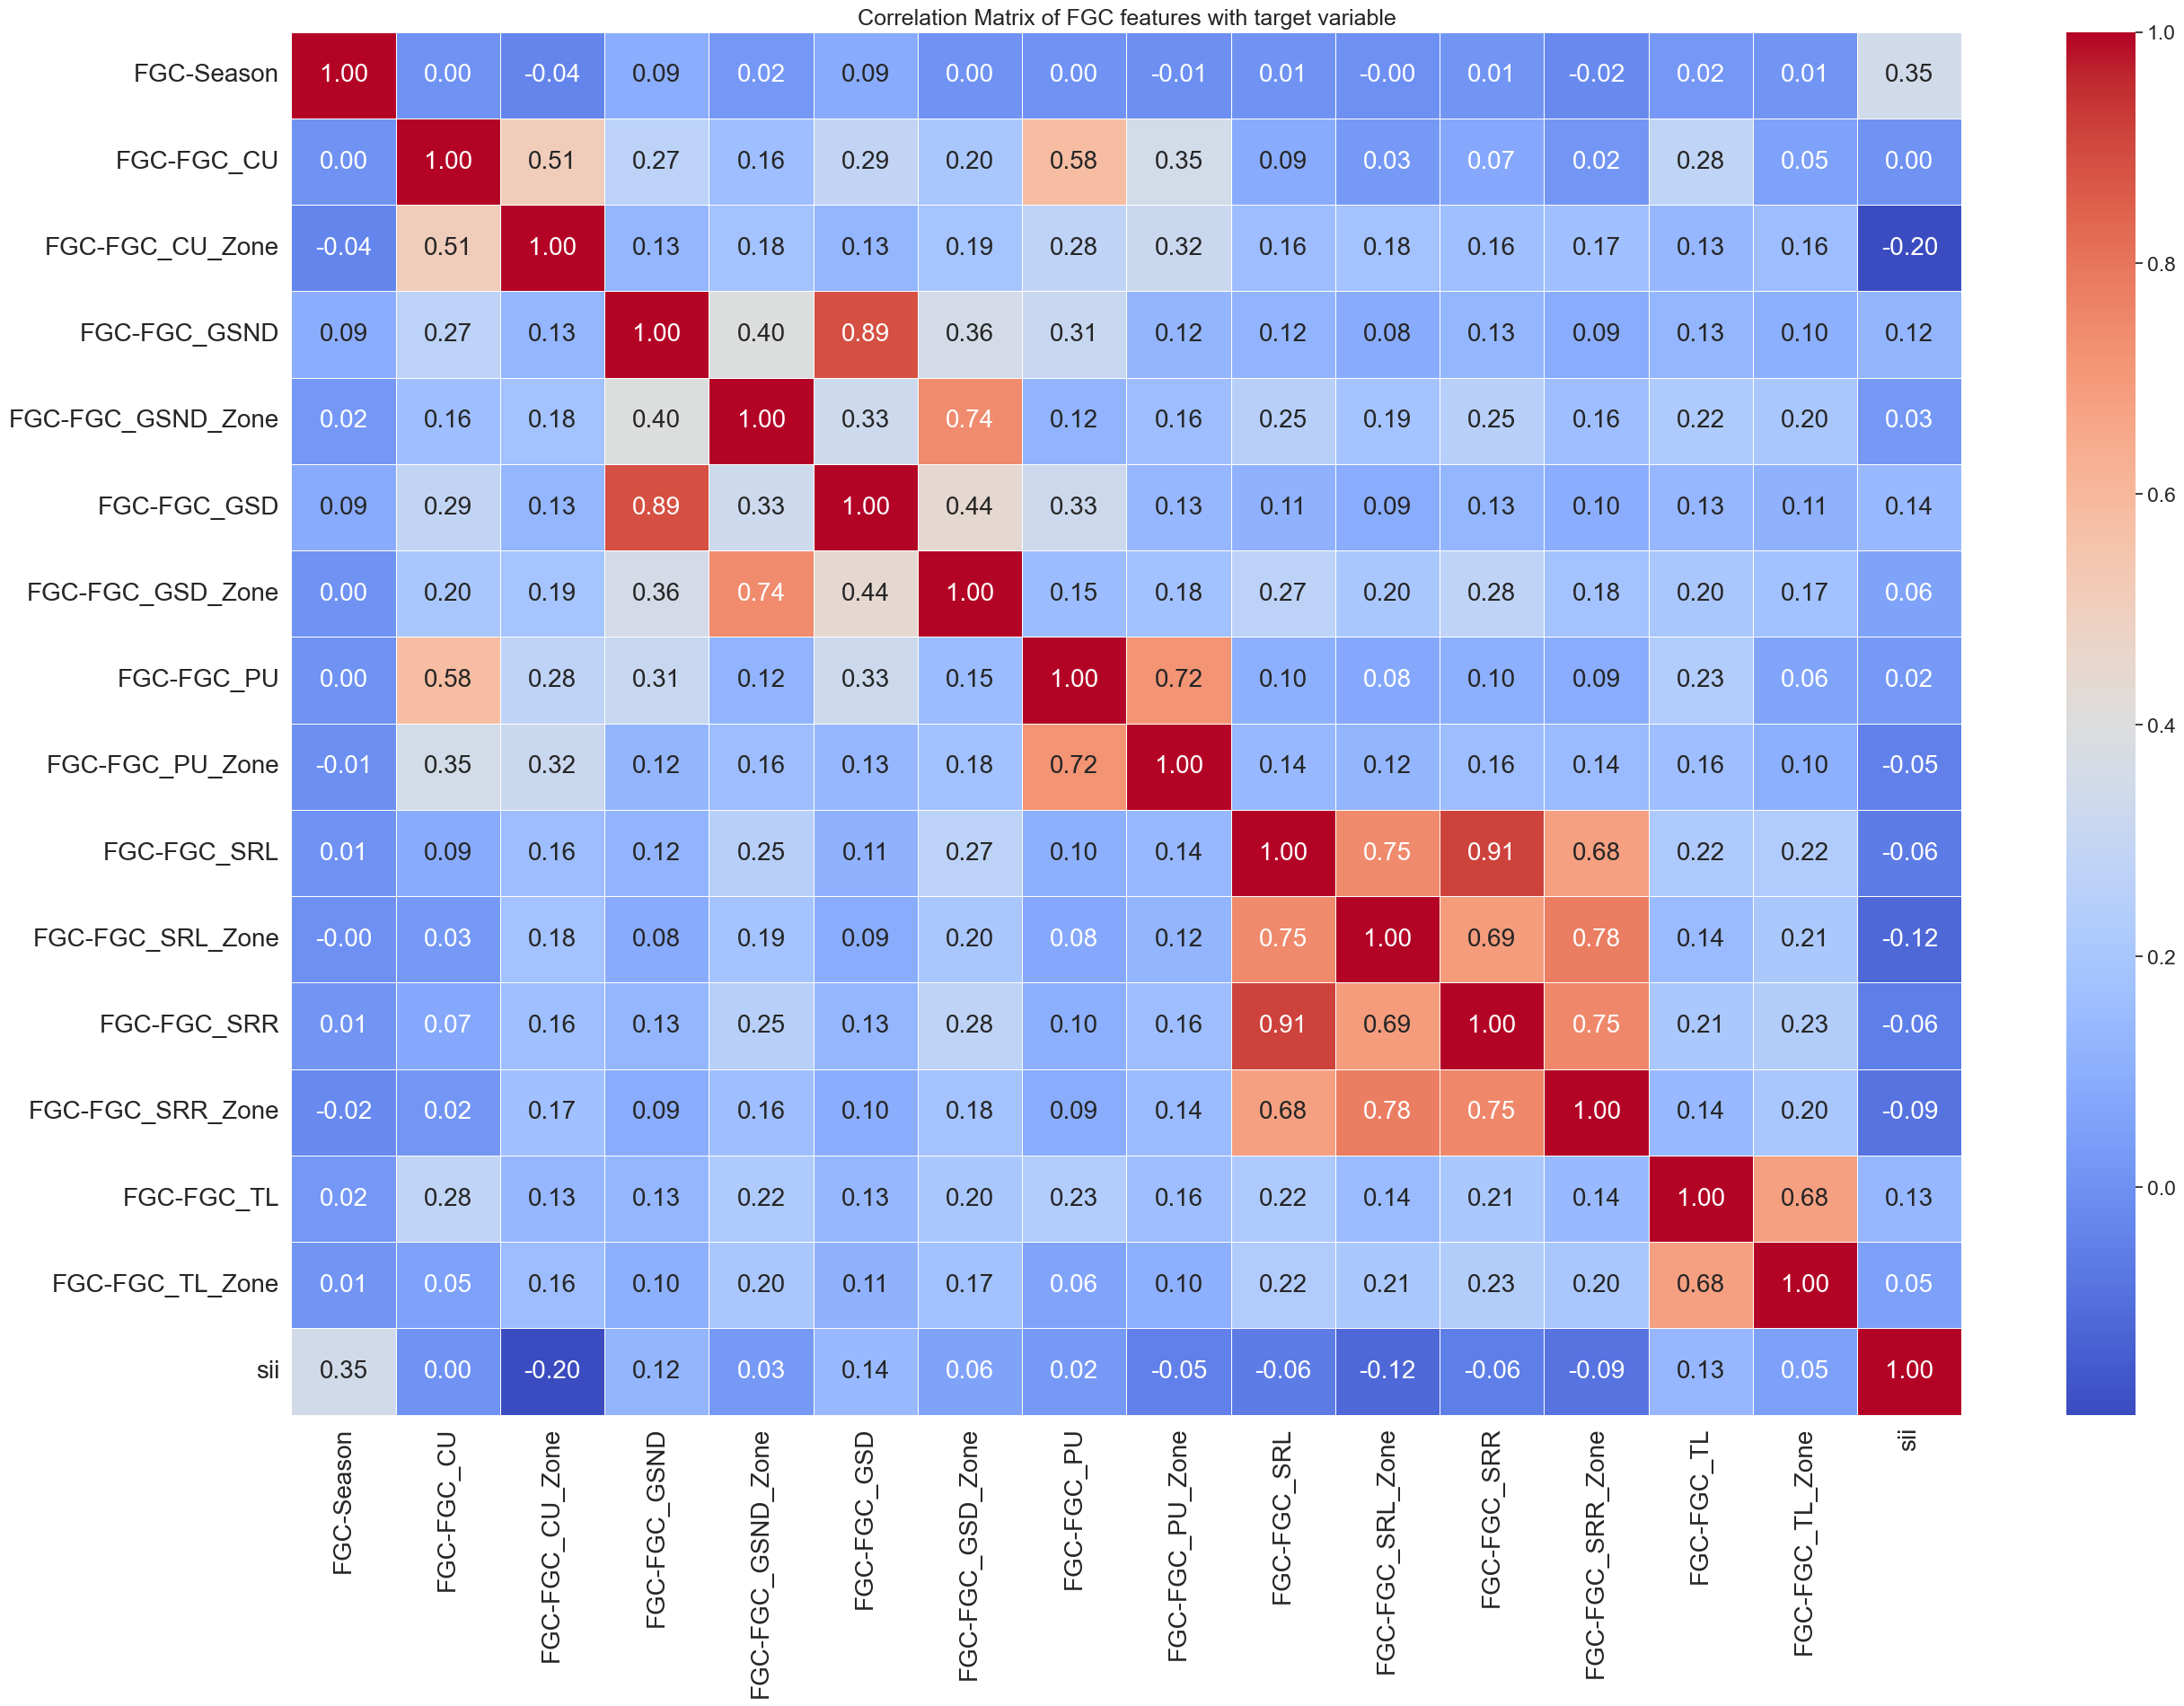

In [47]:

# Correlation of FGC features vs target variable
df_temp = None
df_temp = train.loc[:, train.columns.str.contains('FGC')]
df_temp['sii'] = train['sii']
label_encoder = LabelEncoder()
cat = df_temp.select_dtypes('object').columns.to_list()
for col in cat:
    df_temp[col] = label_encoder.fit_transform(df_temp[col])
    
plt.figure(figsize=(30, 20))
sns.set(font_scale=1.5)
ax = sns.heatmap(df_temp.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, annot_kws={"size": 20})
ax.set_xticklabels(ax.get_xticklabels(), fontsize=20)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=20)

plt.title('Correlation Matrix of FGC features with target variable')
plt.show()
#Findings: None of the features has strong correlation either positive or negative.

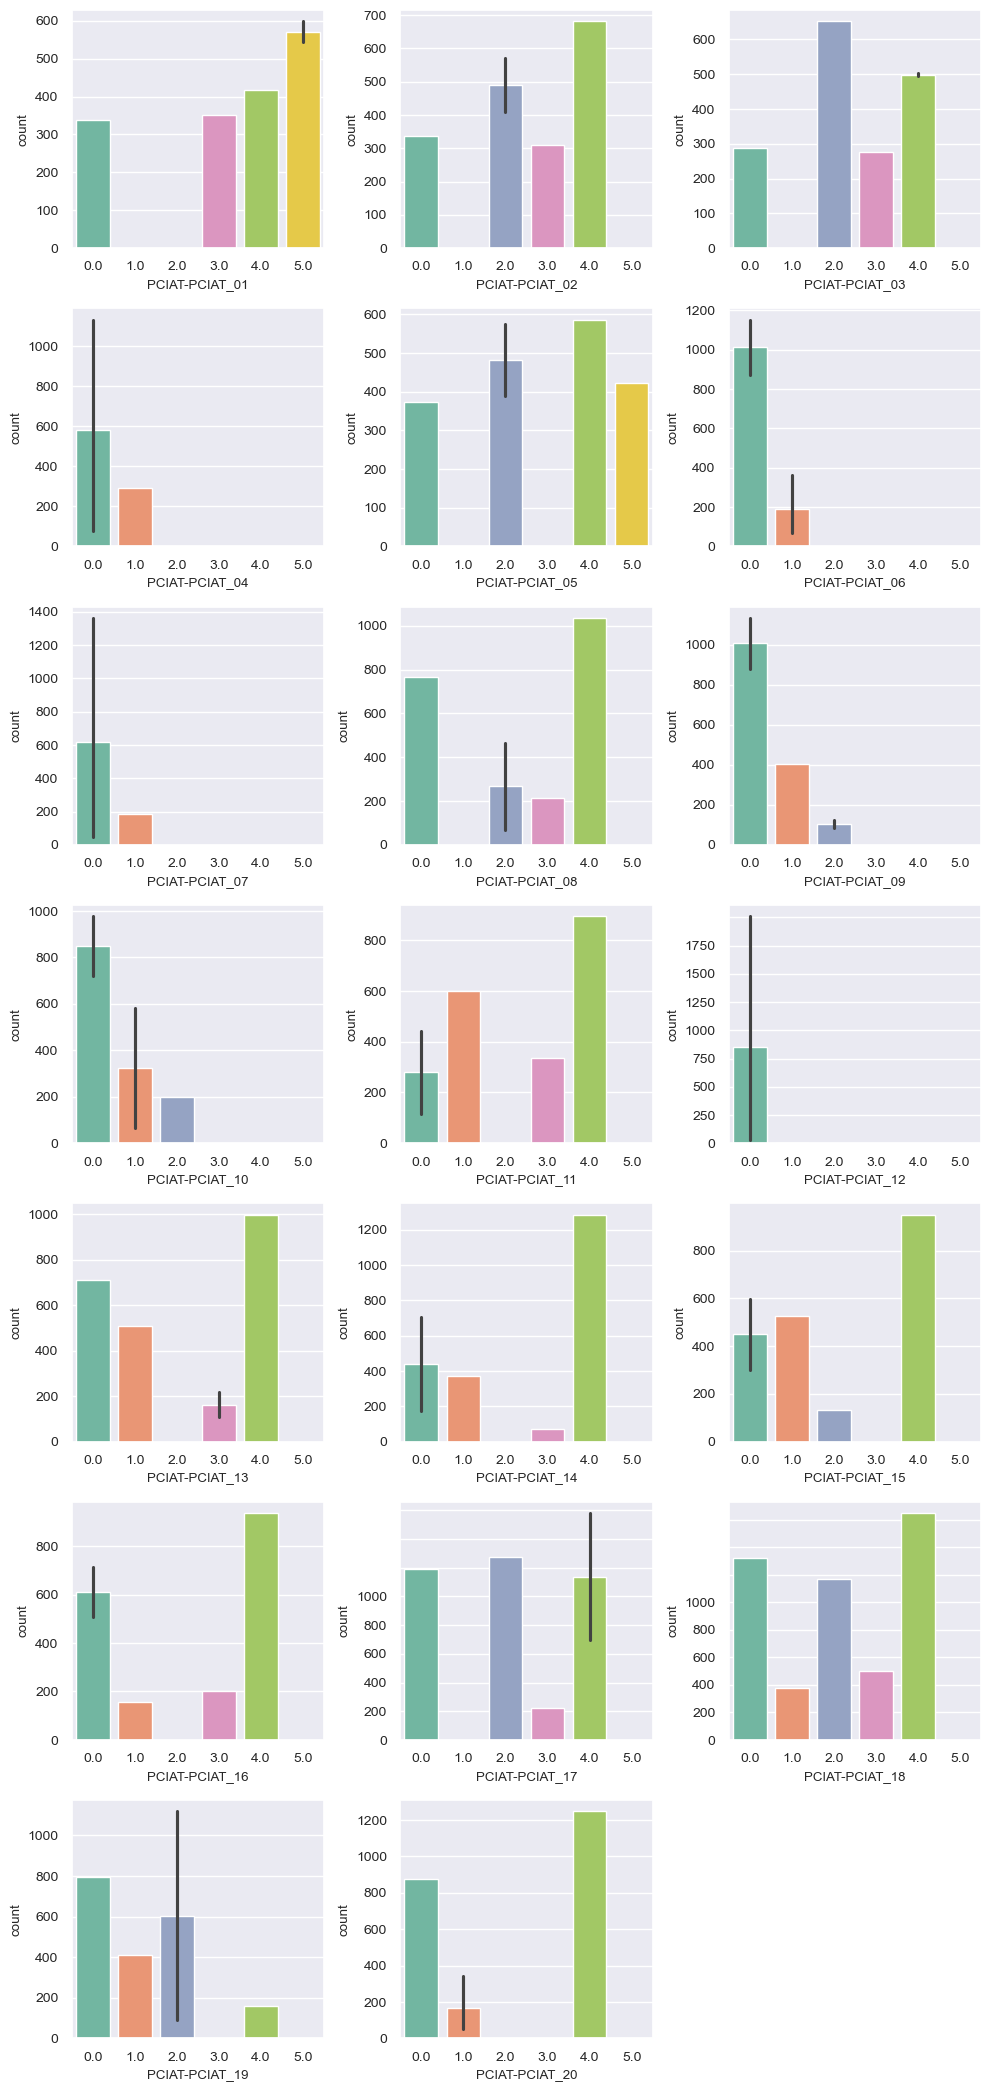

[Text(0, 0.0, '0'),
 Text(0, 100.0, '100'),
 Text(0, 200.0, '200'),
 Text(0, 300.0, '300'),
 Text(0, 400.0, '400'),
 Text(0, 500.0, '500')]

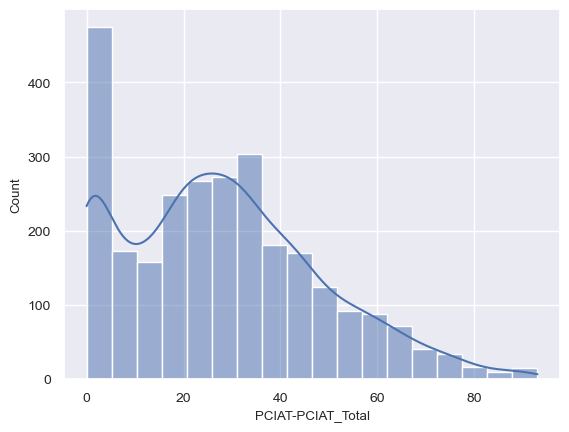

In [63]:
#Count plots of all PCIAT features and the distribution of PCIAT total
df_temp = None
df_temp = train.loc[:, train.columns.str.contains('PCIAT')]
df_temp = df_temp.drop('PCIAT-Season', axis=1)
df_total = df_temp['PCIAT-PCIAT_Total']
df_temp = df_temp.drop('PCIAT-PCIAT_Total', axis=1)


n_features = len(df_temp.columns)
n_cols = 3
n_rows = (n_features // n_cols) + (n_features % n_cols != 0)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 3 * n_rows))
axes = axes.flatten() 
sns.set(font_scale=0.8)
for i, feature in enumerate(df_temp.columns):
    ax= sns.barplot(x=df_temp[feature], y=df_temp[feature].value_counts(), ax=axes[i], palette='Set2')
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=10)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)

for j in range(i + 1, len(axes)):
    axes[j].axis('off')  # Hide the extra subplots

plt.tight_layout()
plt.show()

ax = sns.histplot(x=df_total, kde='True', palette='Set2', bins=18)  
ax.set_xticklabels(ax.get_xticklabels(), fontsize=10)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)

#Findings: Except physical hieght, rest of the features display normal distribution.


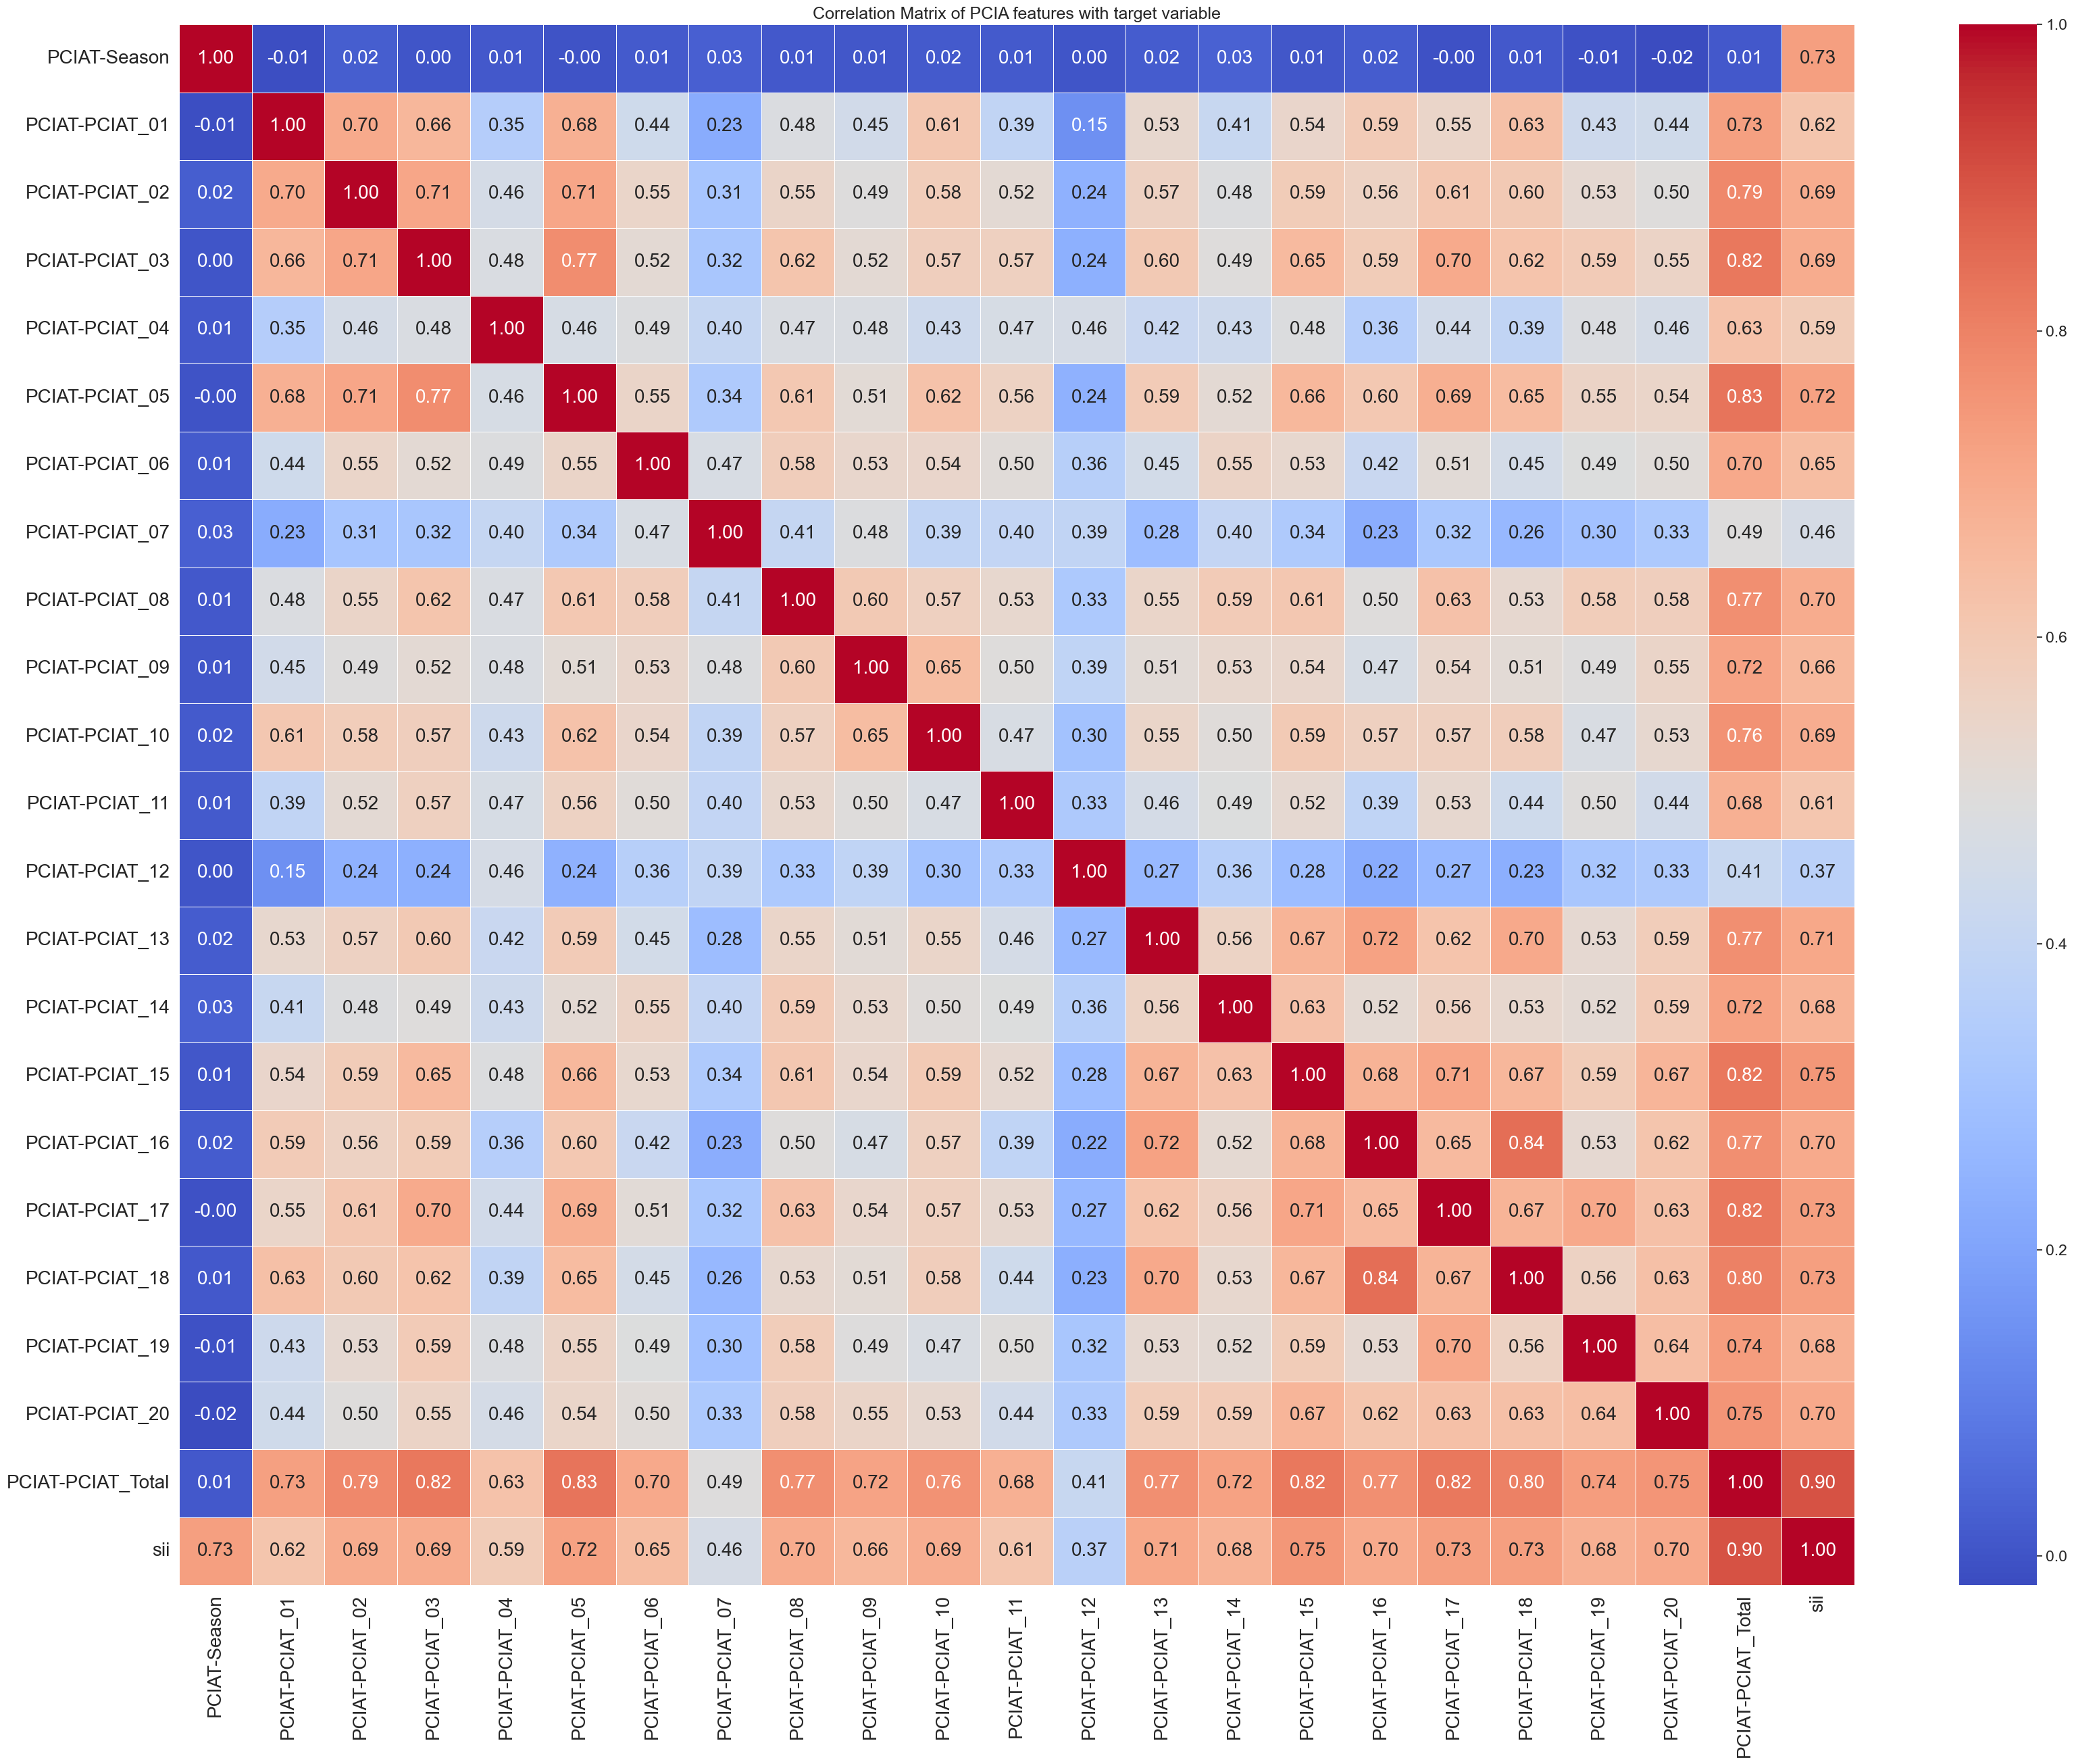

In [49]:

# Correlation of PCIAT columns vs target variable
df_temp = None
df_temp = train.loc[:, train.columns.str.contains('PCIAT')]
df_temp['sii'] = train['sii']
label_encoder = LabelEncoder()
cat = df_temp.select_dtypes('object').columns.to_list()
for col in cat:
    df_temp[col] = label_encoder.fit_transform(df_temp[col])
    
plt.figure(figsize=(40, 30))
sns.set(font_scale=1.5)

ax = sns.heatmap(df_temp.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, annot_kws={"size": 20})
ax.set_xticklabels(ax.get_xticklabels(), fontsize=20)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=20)

plt.title('Correlation Matrix of PCIA features with target variable')
plt.show()
#Findings: The target variable has strong correlation with all PCIAT features. Althogh some of the PCIA features
# are strogly related to each other.

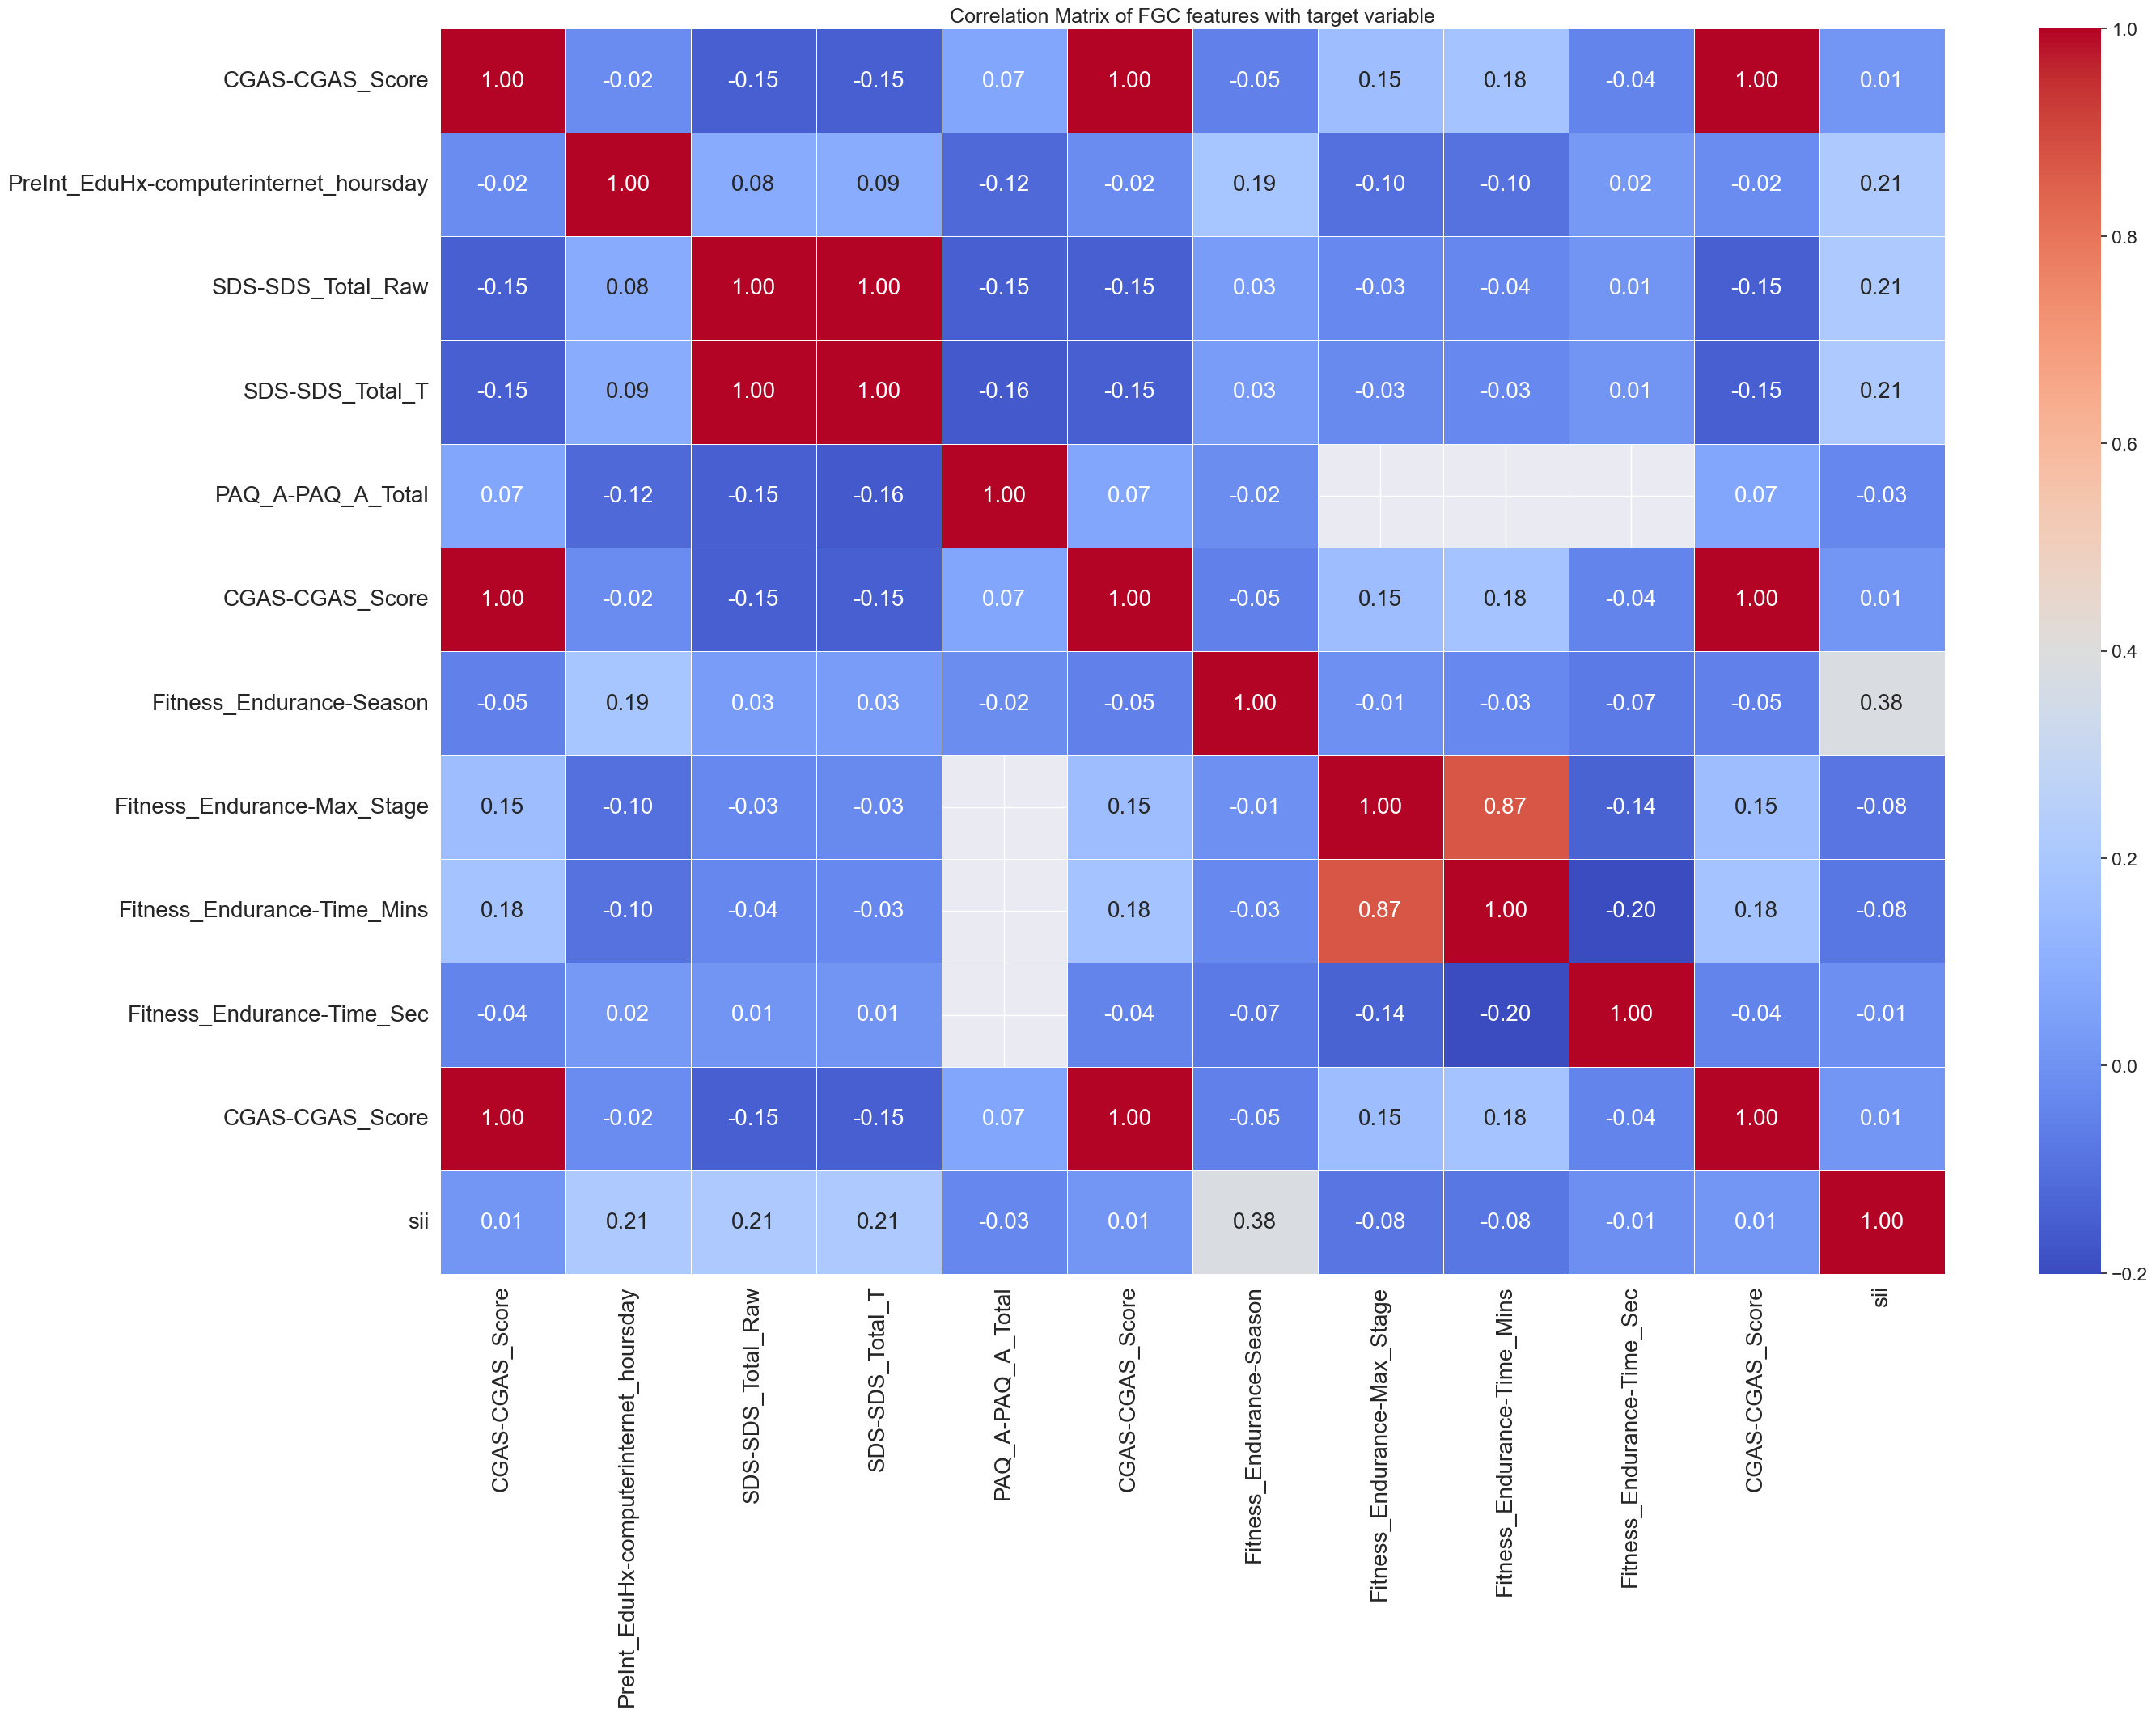

In [50]:
# THe correlation map of resto f the features and the target variable...........
df_temp = None
df_temp = train[['CGAS-CGAS_Score','PreInt_EduHx-computerinternet_hoursday', 'SDS-SDS_Total_Raw'
                 , 'SDS-SDS_Total_T', 'PAQ_A-PAQ_A_Total', 'CGAS-CGAS_Score', 'Fitness_Endurance-Season',
                 'Fitness_Endurance-Max_Stage', 'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec',
                 'CGAS-CGAS_Score', 'sii']]

label_encoder = LabelEncoder()
cat = df_temp.select_dtypes('object').columns.to_list()
for col in cat:
    df_temp[col] = label_encoder.fit_transform(df_temp[col])
    
plt.figure(figsize=(30, 20))
sns.set(font_scale=1.5)
ax = sns.heatmap(df_temp.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, annot_kws={"size": 20})
ax.set_xticklabels(ax.get_xticklabels(), fontsize=20)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=20)
plt.title('Correlation Matrix of FGC features with target variable')
plt.show()
#Findings: None of the features has strong correlation either positive or negative.

In [51]:
def process_parquet_files(file_name, dir_name):


    df = pd.read_parquet(os.path.join(dir_name, file_name, 'part-0.parquet'))
       
    
    return df.mean().values.reshape(-1), file_name.split('=')[1]



In [52]:
def read_parquet_file_corr(dir_name):

    files_list = os.listdir(dir_name)
    #files_list = ['id=0a418b57', 'id=0a431608']
    for file in files_list:
        if file == '.DS_Store':
            files_list.remove('.DS_Store')
    with ThreadPoolExecutor() as executor:
        results = list(executor.map(lambda fname: process_parquet_files(fname, dir_name), files_list))

        
    stats, indexes = zip(*results)
    df = pd.DataFrame(stats, columns=[f"stat_{i}" for i in range(len(stats[0]))])
    df['id'] = indexes
    return df


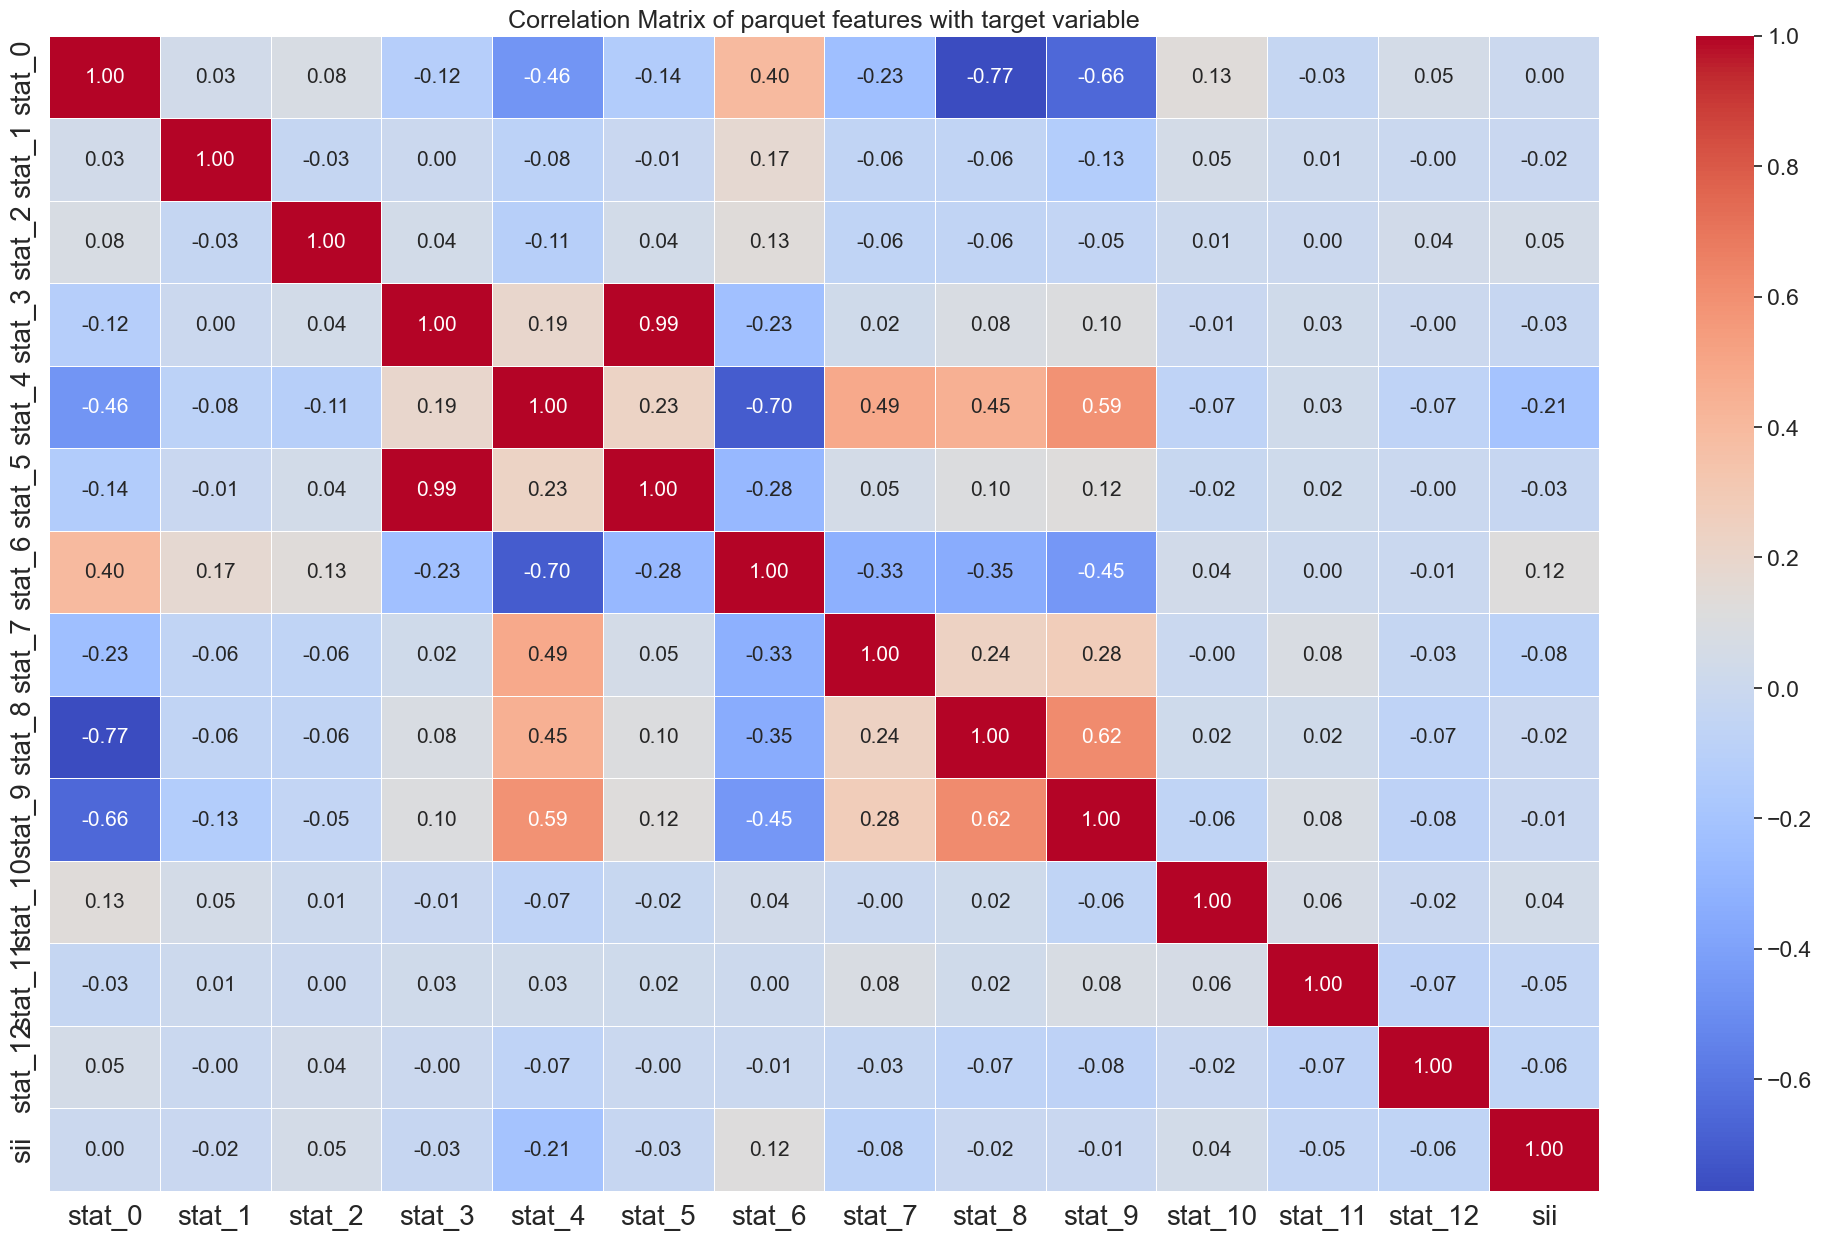

In [53]:
#Correlation map of all accelometer features with the target variable.........
#TO map the correlation, the data from csv files and parquet files are merged and crerated a dataframe.
df_parquet = None
dir_name = 'child-mind-institute-problematic-internet-use/'
    
df_parquet = read_parquet_file_corr(os.path.join(dir_name,'series_train.parquet/'))
df_parquet_merged = pd.merge(train, df_parquet, how="inner", on='id')
#df_parquet_merged
# Notes: All the participant with the unique id does not have accelometer data, there are 3960 rows in the 
# train.csv while there are only 996 parquet files. So each participant does not have accelometer data.
#The following dataframe compromises all the features including the demographical and accelometer features on for
#the 996 participants.

# Lets visualize the relationship between accelometer data and the target variable.
df_temp = None
df_temp = df_parquet_merged.loc[:, df_parquet_merged.columns.str.contains('stat')]
df_temp['sii'] = df_parquet_merged['sii']

plt.figure(figsize=(25, 15))
sns.set(font_scale=1.5)
ax = sns.heatmap(df_temp.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, annot_kws={"size": 15})
ax.set_xticklabels(ax.get_xticklabels(), fontsize=20)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=20)

plt.title('Correlation Matrix of parquet features with target variable')
plt.show()
#Findings: No strong relationship is visible between these features and the target variable.


In [54]:
# The following correlation map is created between all features including csv and parquet features and map the 
#corrrelation with the target variable. THe purpose to plot this correlation is to find the features that can
#be used to fill the null values in other features.
#Strategy is to use the features with highest corelation either positive or negative to plot the null values of
#the features.

df_parquet = None
dir_name = 'child-mind-institute-problematic-internet-use/'
    
df_parquet = read_parquet_file_corr(os.path.join(dir_name,'series_train.parquet/'))
df_parquet_merged = pd.merge(train, df_parquet, how="inner", on='id')
#df_parquet_merged
# Notes: All the participant with the unique id does not have accelometer data, there are 3960 rows in the 
# train.csv while there are only 996 parquet files. So each participant does not have accelometer data.
#The following dataframe compromises all the features including the demographical and accelometer features on for
#the 996 participants.

label_encoder = LabelEncoder()
cat = df_parquet_merged.select_dtypes('object').columns.to_list()
for col in cat:
    df_parquet_merged[col] = label_encoder.fit_transform(df_parquet_merged[col])
 
#plt.figure(figsize=(100, 80))
#sns.set(font_scale=1.5)
#ax = sns.heatmap(df_parquet_merged.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, annot_kws={"size": 20})
#ax.set_xticklabels(ax.get_xticklabels(), fontsize=20)
#ax.set_yticklabels(ax.get_yticklabels(), fontsize=20)

#plt.title('Correlation Matrix of parquet features with target variable')
#plt.show()
#Findings: No strong relationship is visible between these features and the target variable.


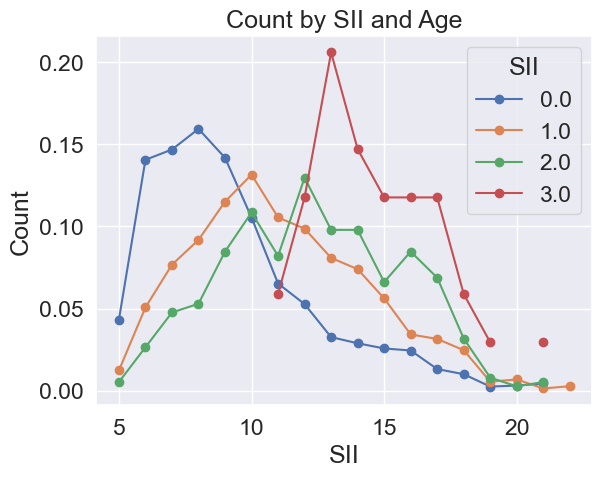

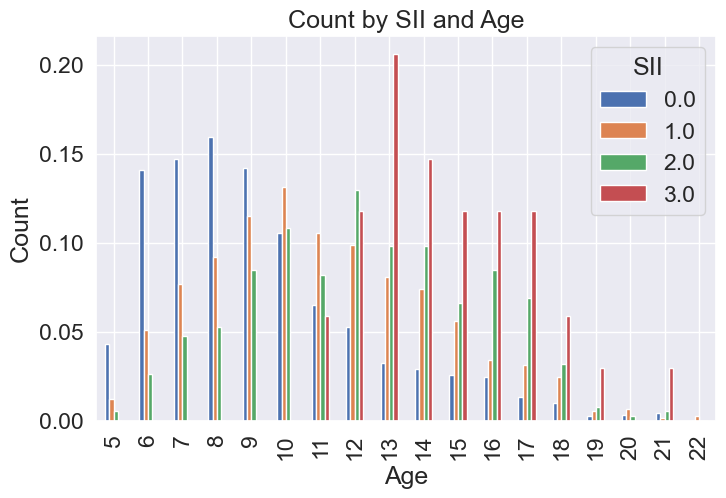

In [55]:
#Queries
# No:1
# Age vs sii

df_temp=None
df_temp = train.groupby('sii')[['Basic_Demos-Age']].value_counts(normalize=True)
df_temp

# Line plot
df_unstacked = df_temp.unstack(level='sii')  # Unstack 'Age' level
df_unstacked.plot(kind='line', marker='o')
plt.title('Count by SII and Age')
plt.ylabel('Count')
plt.xlabel('SII')
plt.legend(title='SII')
plt.show()
# Bar plot
df_unstacked.plot(kind='bar', figsize=(8, 5))
plt.title('Count by SII and Age')
plt.ylabel('Count')
plt.xlabel('Age')
plt.legend(title='SII')
plt.show()
#Findings: Both plots revealed that there is a relationship between age and severity index.
#Critical age span is between 11 to 19 where the severity index start get intesing and the less severity index
#start decreasing.

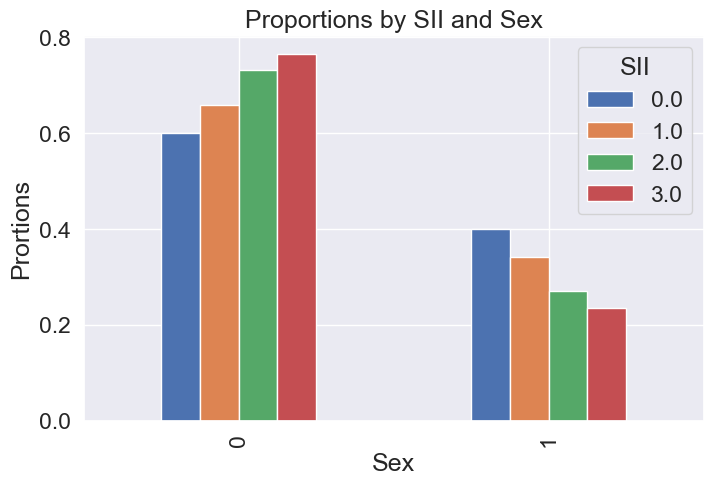

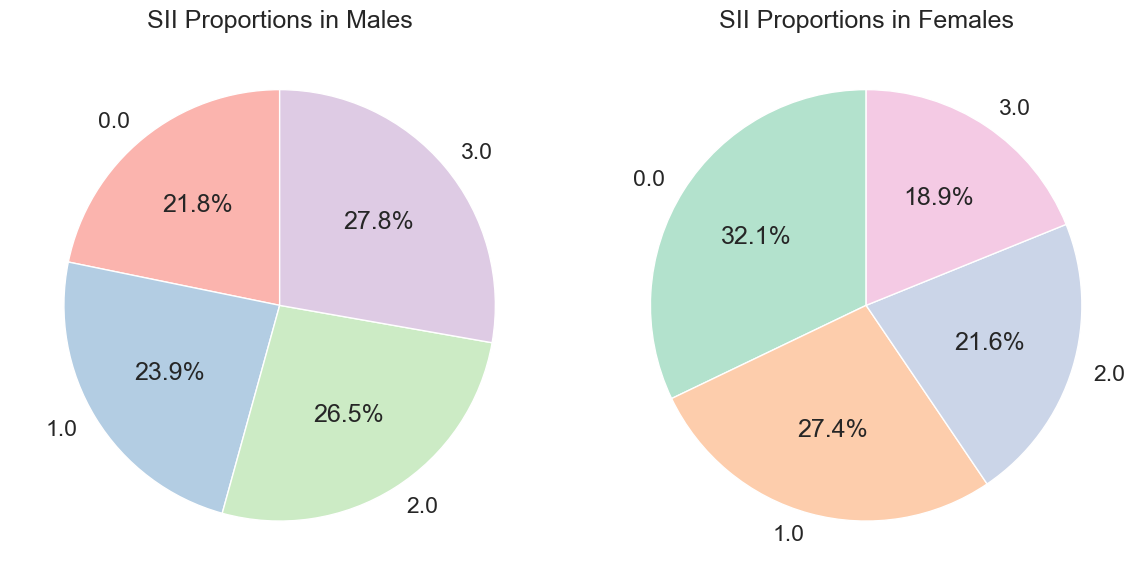

In [56]:
df_temp=None
df_temp = train.groupby('sii')[['Basic_Demos-Sex']].value_counts(normalize=True)


# Bar plot
df_unstacked = df_temp.unstack(level='sii')  # Unstack 'Age' level
df_unstacked.plot(kind='bar', figsize=(8, 5))
plt.title('Proportions by SII and Sex')
plt.ylabel('Prortions')
plt.xlabel('Sex')
plt.legend(title='SII')
plt.show()


df_temp_flat = df_temp.reset_index()  # Flatten for easier manipulation

male_colors = plt.cm.Pastel1.colors  # Lighter colors for males
female_colors = plt.cm.Pastel2.colors  # Lighter colors for females

# Separate data for Male and Female
male_data = df_temp_flat[df_temp_flat['Basic_Demos-Sex'] == 0].set_index('sii')['proportion']
female_data = df_temp_flat[df_temp_flat['Basic_Demos-Sex'] == 1].set_index('sii')['proportion']

# Create subplots for side-by-side pie charts
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot male pie chart
axes[0].pie(male_data, labels=male_data.index, autopct='%1.1f%%', startangle=90, colors=male_colors)
axes[0].set_title('SII Proportions in Males')

# Plot female pie chart
axes[1].pie(female_data, labels=female_data.index, autopct='%1.1f%%', startangle=90, colors=female_colors)
axes[1].set_title('SII Proportions in Females')

# Display the plot
plt.tight_layout()
plt.show()
#Findings: The sii intensity rate is high pretty in male as respect to females.

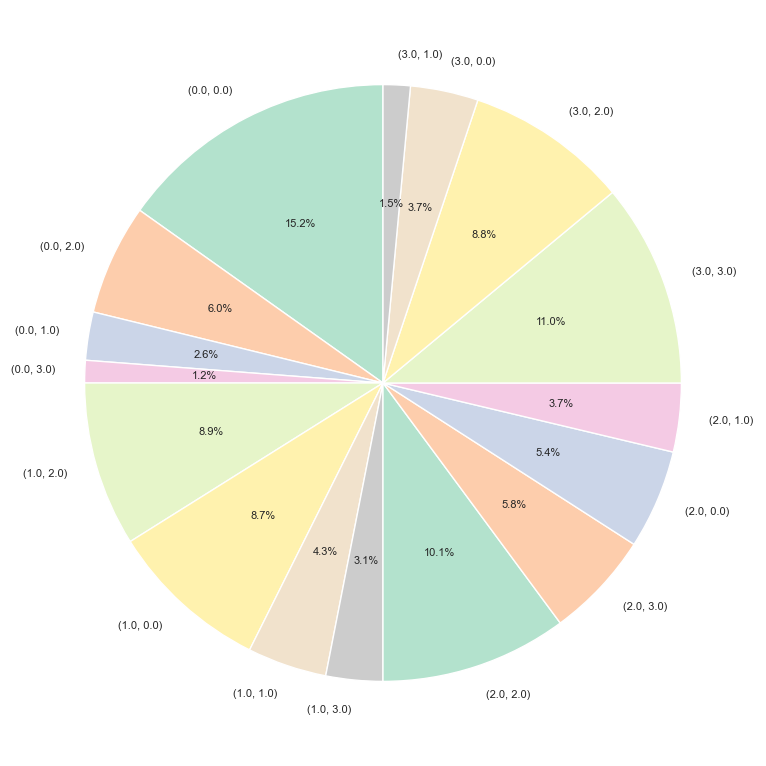

In [57]:
df_temp=None

df_temp = train.groupby('sii')[['PreInt_EduHx-computerinternet_hoursday']].value_counts(normalize=True)


plt.figure(figsize=(10, 8))

# Plot male pie chart
plt.pie(df_temp, labels=df_temp.index, autopct='%1.1f%%', startangle=90, 
        textprops={'fontsize' : 8}, colors=plt.cm.Pastel2.colors)


# Display the plot
plt.tight_layout()
plt.show()
#Findings: The si

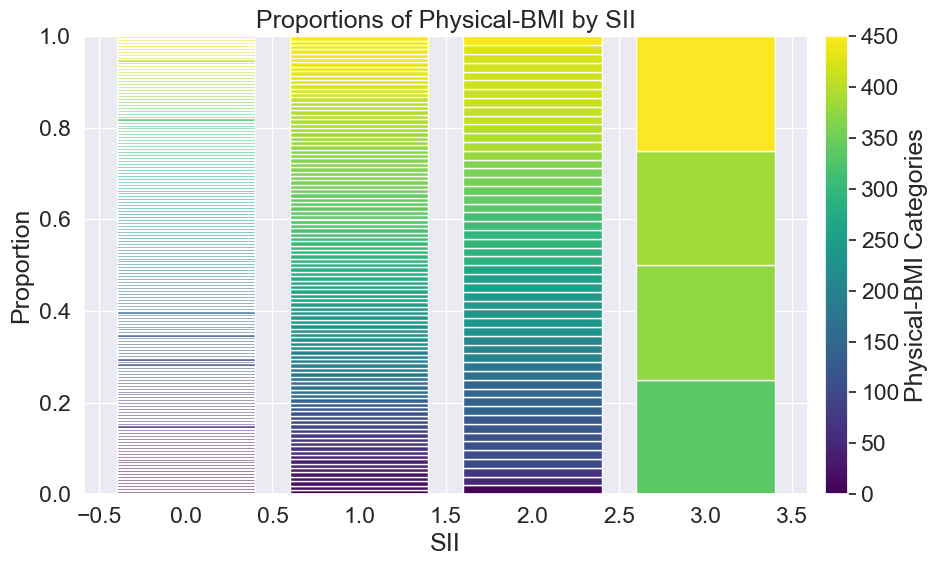

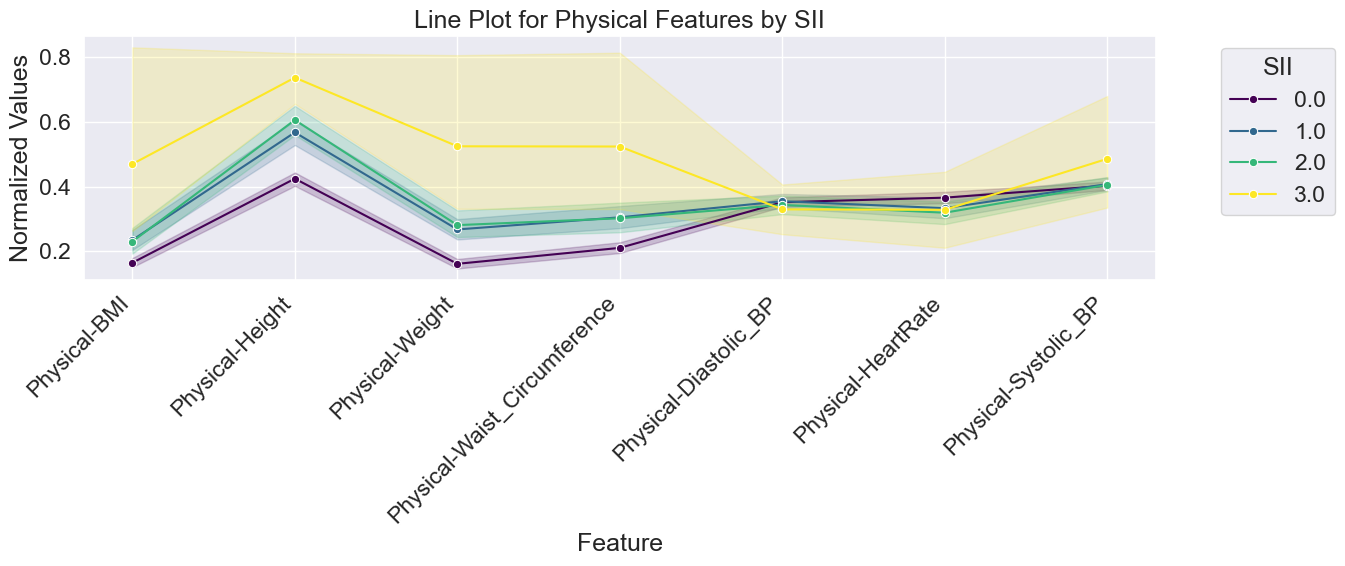

In [58]:
# Lets examin the relationship between physical features and the sii.
import matplotlib.colors as mcolors
df_temp = None
df_temp = train.loc[:, train.columns.str.contains('Physical')]
df_temp = train.groupby('sii')[['Physical-BMI','Physical-Height','Physical-Weight','Physical-Waist_Circumference',
'Physical-Diastolic_BP','Physical-HeartRate','Physical-Systolic_BP']].value_counts(normalize=True)

df_temp_flat = df_temp.reset_index()
# Pivot the data
df_pivot = df_temp_flat.pivot_table(index='sii', columns='Physical-BMI', values='proportion', aggfunc='sum')

# Define the colormap
colormap = plt.cm.viridis
norm = mcolors.Normalize(vmin=0, vmax=len(df_pivot.columns) - 1)

# Plot as stacked bar chart
fig, ax = plt.subplots(figsize=(10, 6))

# Loop to plot each column with the corresponding color
for i, column in enumerate(df_pivot.columns):
    ax.bar(df_pivot.index, df_pivot[column], bottom=df_pivot.iloc[:, :i].sum(axis=1), 
           color=colormap(norm(i)), label=column)

# Add a color bar instead of a legend
sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, orientation='vertical', pad=0.02)
cbar.set_label('Physical-BMI Categories')

# Titles and labels
ax.set_title('Proportions of Physical-BMI by SII')
ax.set_ylabel('Proportion')
ax.set_xlabel('SII')

plt.tight_layout()
plt.show()

from pandas.plotting import parallel_coordinates

# Normalize physical features
features = ['Physical-BMI', 'Physical-Height', 'Physical-Weight',
            'Physical-Waist_Circumference', 'Physical-Diastolic_BP',
            'Physical-HeartRate', 'Physical-Systolic_BP']

df_parallel = df_temp_flat.copy()
df_parallel[features] = df_parallel[features].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

# Melt the data for seaborn
df_melted = pd.melt(df_parallel, id_vars=['sii'], value_vars=features, 
                    var_name='Feature', value_name='Value')

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_melted, x='Feature', y='Value', hue='sii', marker='o', palette='viridis')
plt.title('Line Plot for Physical Features by SII')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Normalized Values')
plt.tight_layout()
plt.legend(title='SII', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()
# Findings: With increae in intensity of sii, phsicla BMI increase, hence the physical height and specialy weight.
#the kids in intense severity index demonstrate high BMI with the normal heart rate but notibly high systollic BP.

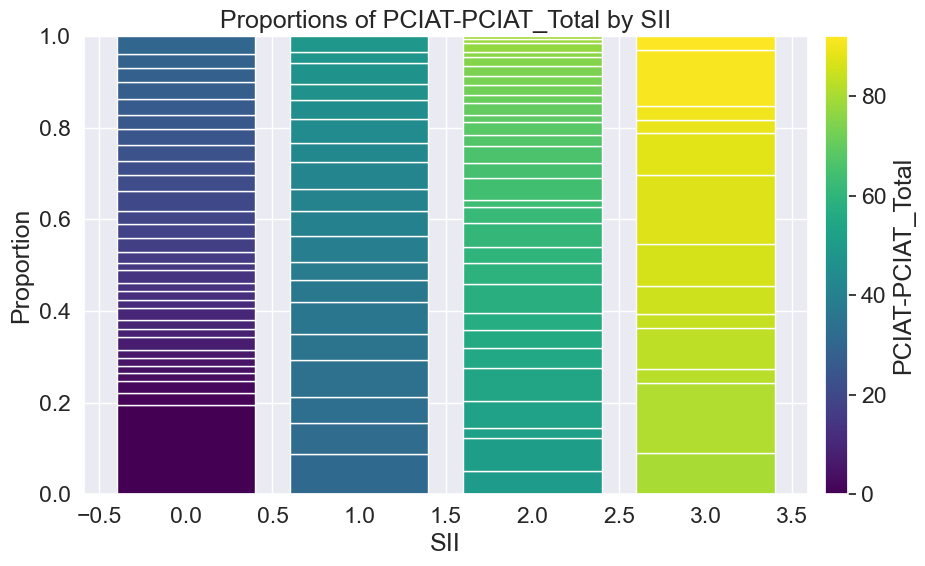

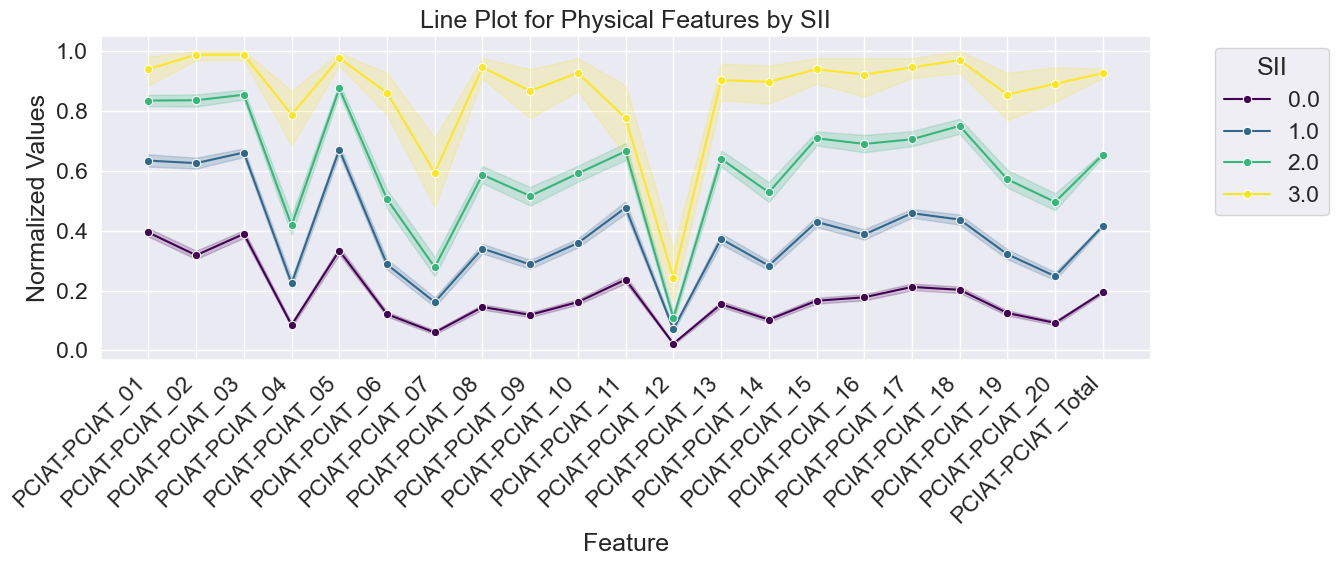

In [59]:
# Relationship between PCIAT features and the sii.
df_temp = None
#df_temp = train.loc[:, train.columns.str.contains('PCIAT')]
df_temp = train.groupby('sii')[['PCIAT-PCIAT_01','PCIAT-PCIAT_02','PCIAT-PCIAT_03','PCIAT-PCIAT_04',
'PCIAT-PCIAT_05','PCIAT-PCIAT_06','PCIAT-PCIAT_07','PCIAT-PCIAT_08','PCIAT-PCIAT_09','PCIAT-PCIAT_10',
'PCIAT-PCIAT_11','PCIAT-PCIAT_12','PCIAT-PCIAT_13','PCIAT-PCIAT_14','PCIAT-PCIAT_15','PCIAT-PCIAT_16',
'PCIAT-PCIAT_17','PCIAT-PCIAT_18','PCIAT-PCIAT_19','PCIAT-PCIAT_20','PCIAT-PCIAT_Total']].value_counts(normalize=True)

df_temp_flat = df_temp.reset_index()
# Pivot the data
df_pivot = df_temp_flat.pivot_table(index='sii', columns='PCIAT-PCIAT_Total', values='proportion', aggfunc='sum')

# Define the colormap
colormap = plt.cm.viridis
norm = mcolors.Normalize(vmin=0, vmax=len(df_pivot.columns) - 1)

# Plot as stacked bar chart
fig, ax = plt.subplots(figsize=(10, 6))

# Loop to plot each column with the corresponding color
for i, column in enumerate(df_pivot.columns):
    ax.bar(df_pivot.index, df_pivot[column], bottom=df_pivot.iloc[:, :i].sum(axis=1), 
           color=colormap(norm(i)), label=column)

# Add a color bar instead of a legend
sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, orientation='vertical', pad=0.02)
cbar.set_label('PCIAT-PCIAT_Total')

# Titles and labels
ax.set_title('Proportions of PCIAT-PCIAT_Total by SII')
ax.set_ylabel('Proportion')
ax.set_xlabel('SII')

plt.tight_layout()
plt.show()

from pandas.plotting import parallel_coordinates

# Normalize physical features
features = ['PCIAT-PCIAT_01','PCIAT-PCIAT_02','PCIAT-PCIAT_03','PCIAT-PCIAT_04',
'PCIAT-PCIAT_05','PCIAT-PCIAT_06','PCIAT-PCIAT_07','PCIAT-PCIAT_08','PCIAT-PCIAT_09','PCIAT-PCIAT_10',
'PCIAT-PCIAT_11','PCIAT-PCIAT_12','PCIAT-PCIAT_13','PCIAT-PCIAT_14','PCIAT-PCIAT_15','PCIAT-PCIAT_16',
'PCIAT-PCIAT_17','PCIAT-PCIAT_18','PCIAT-PCIAT_19','PCIAT-PCIAT_20','PCIAT-PCIAT_Total']

df_parallel = df_temp_flat.copy()
df_parallel[features] = df_parallel[features].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

# Melt the data for seaborn
df_melted = pd.melt(df_parallel, id_vars=['sii'], value_vars=features, 
                    var_name='Feature', value_name='Value')

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_melted, x='Feature', y='Value', hue='sii', marker='o', palette='viridis')
plt.title('Line Plot for Physical Features by SII')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Normalized Values')
plt.tight_layout()
plt.legend(title='SII', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()
# PCIAT represent the questionare filled by the paretns about their child behavior. Heatmap revealed a strong 
# correlation between PCIAT features and sii. From the first plot it is colors range from bottom to top represents
#intensity level of each behavior. It is evident that the behavior is pretty instense as we approch to severity 
#index.
#Note: PCIAT-12 is about recieving the anonymous calls and the answer is no by most of the parents.
# High values of each question leads to intense level pf sii.

<Figure size 1200x600 with 0 Axes>

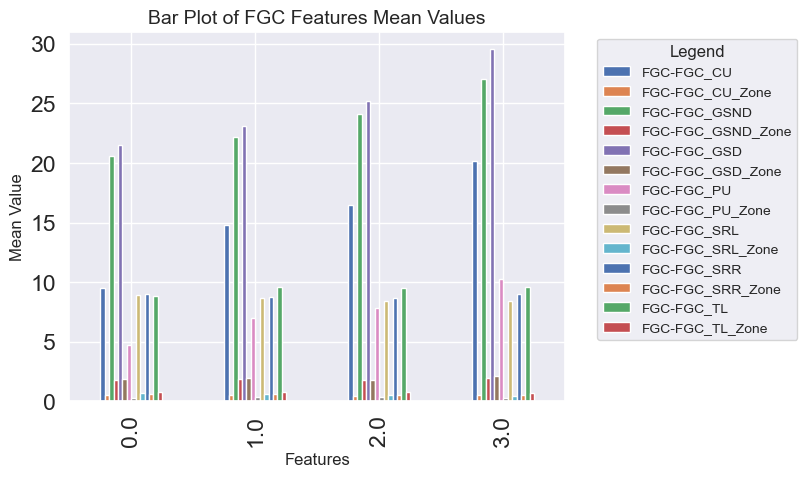

In [60]:
# FCG features represents 
df_temp = None
#df_temp = train.loc[:, train.columns.str.contains('FCG')]
df_temp = train.groupby('sii')[['FGC-FGC_CU','FGC-FGC_CU_Zone','FGC-FGC_GSND','FGC-FGC_GSND_Zone',
'FGC-FGC_GSD','FGC-FGC_GSD_Zone','FGC-FGC_PU','FGC-FGC_PU_Zone','FGC-FGC_SRL','FGC-FGC_SRL_Zone',
'FGC-FGC_SRR','FGC-FGC_SRR_Zone','FGC-FGC_TL','FGC-FGC_TL_Zone']].mean()


plt.figure(figsize=(12, 6))


df_temp.plot.bar()
plt.legend(
    bbox_to_anchor=(1.05, 1),  # Position the legend to the right
    loc='upper left',          # Align with the upper left of bbox_to_anchor
    fontsize=10,               # Reduce the font size
    title="Legend",            # Optional: Title for the legend
    title_fontsize=12          # Adjust legend title font size
)

# Add title and labels for better context
plt.title("Bar Plot of FGC Features Mean Values", fontsize=14)
plt.ylabel("Mean Value", fontsize=12)
plt.xlabel("Features", fontsize=12)
plt.show()
# Findings: There seems a symetrical behavior, for intense level of sii, FCG values tends to high.

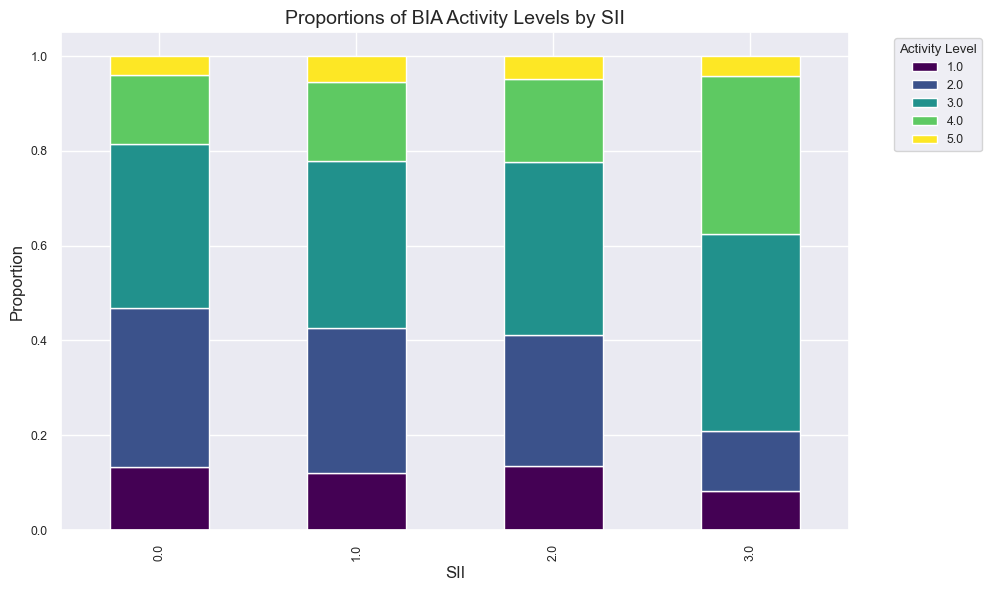

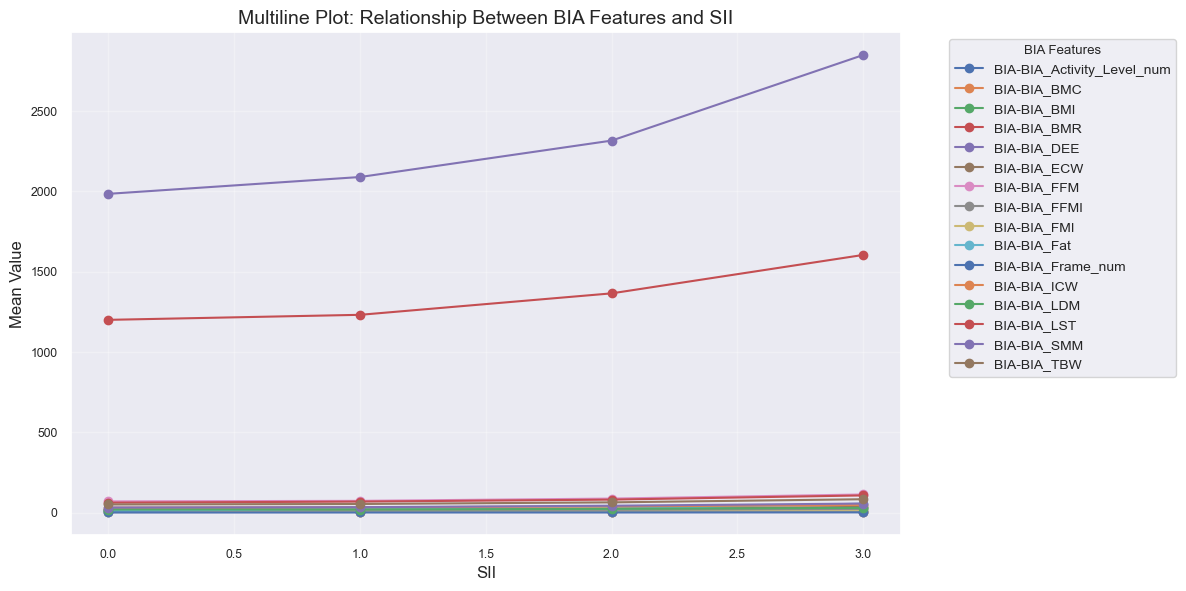

In [69]:
# BIA features analysis
# Relationship between PCIAT features and the sii.
# FCG features represents 
# Compute proportions
df_temp = train.groupby(['sii', 'BIA-BIA_Activity_Level_num']).size().reset_index(name='count')
df_temp['proportion'] = df_temp['count'] / df_temp.groupby('sii')['count'].transform('sum')

# Pivot for easier plotting
df_pivot = df_temp.pivot(index='sii', columns='BIA-BIA_Activity_Level_num', values='proportion')

# Stacked bar plot
df_pivot.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='viridis')
plt.title('Proportions of BIA Activity Levels by SII', fontsize=14)
plt.ylabel('Proportion', fontsize=12)
plt.xlabel('SII', fontsize=12)
plt.legend(title='Activity Level', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

df_temp = None
df_temp = train.groupby('sii')[['BIA-BIA_Activity_Level_num','BIA-BIA_BMC','BIA-BIA_BMI','BIA-BIA_BMR'
,'BIA-BIA_DEE','BIA-BIA_ECW','BIA-BIA_FFM','BIA-BIA_FFMI','BIA-BIA_FMI','BIA-BIA_Fat','BIA-BIA_Frame_num'
,'BIA-BIA_ICW','BIA-BIA_LDM','BIA-BIA_LST','BIA-BIA_SMM','BIA-BIA_TBW'
 ]].mean()


# Plot multiline plot
plt.figure(figsize=(12, 6))
for feature in df_temp.columns:
    plt.plot(df_temp.index, df_temp[feature], label=feature, marker='o', linestyle='-')

# Customize the plot
plt.title('Multiline Plot: Relationship Between BIA Features and SII', fontsize=14)
plt.xlabel('SII', fontsize=12)
plt.ylabel('Mean Value', fontsize=12)
plt.legend(title='BIA Features', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()



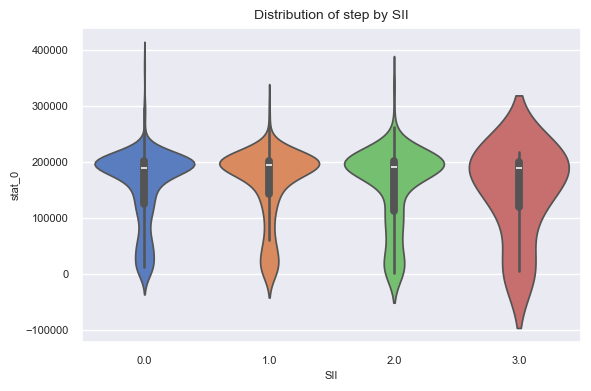

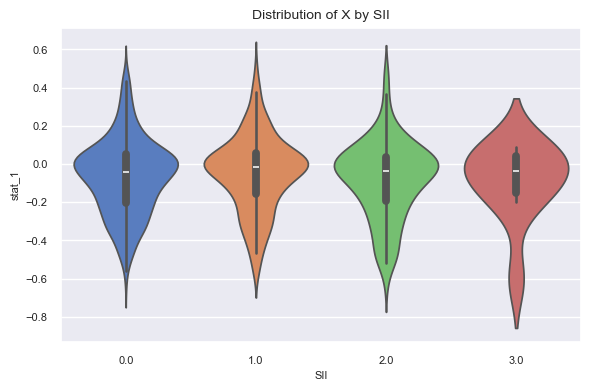

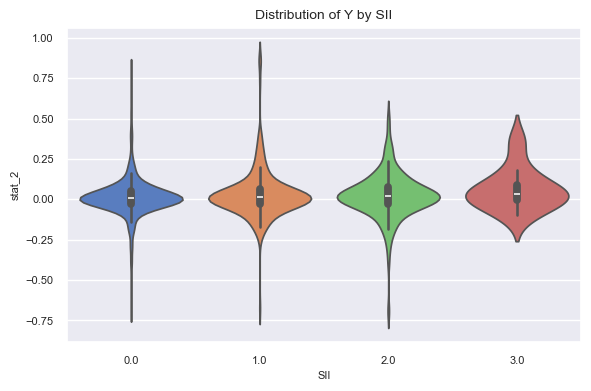

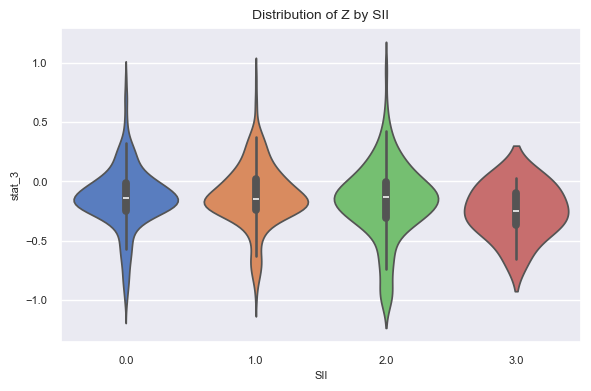

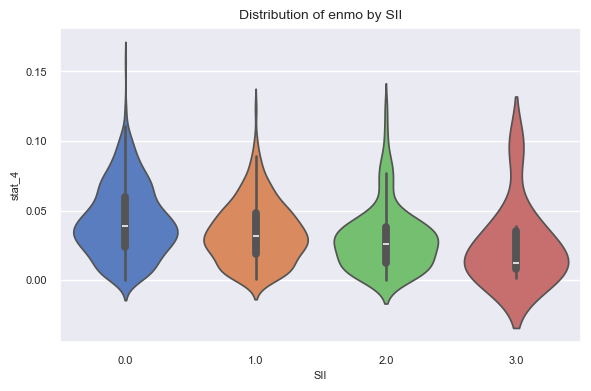

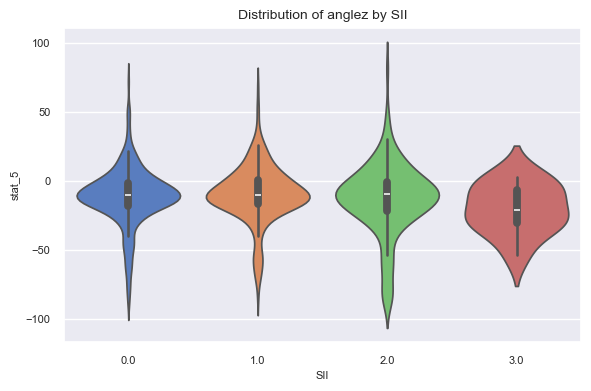

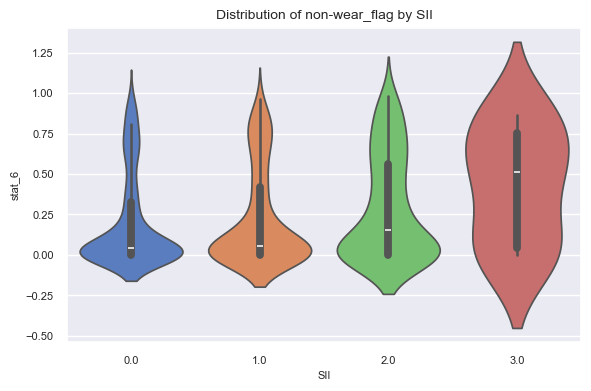

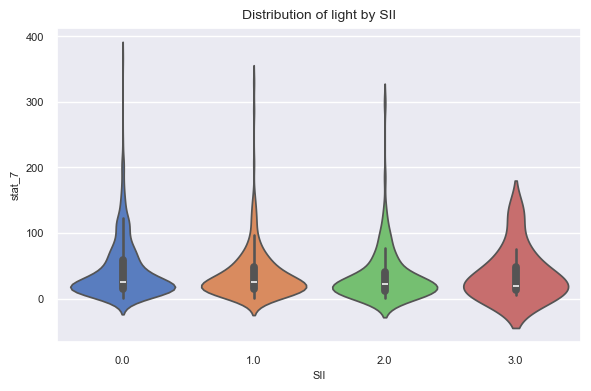

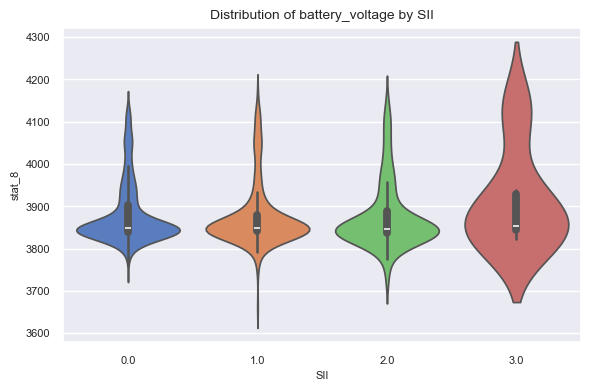

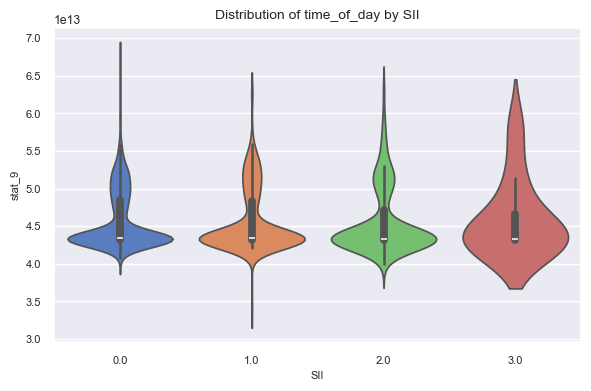

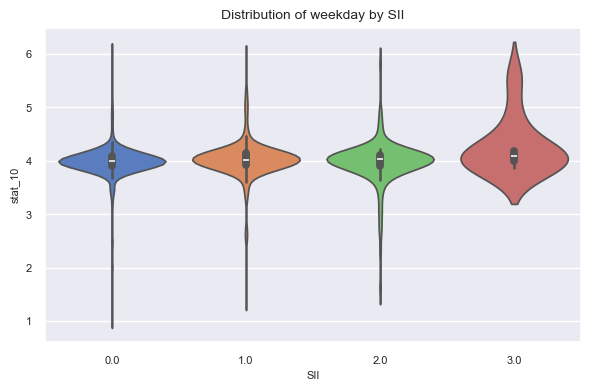

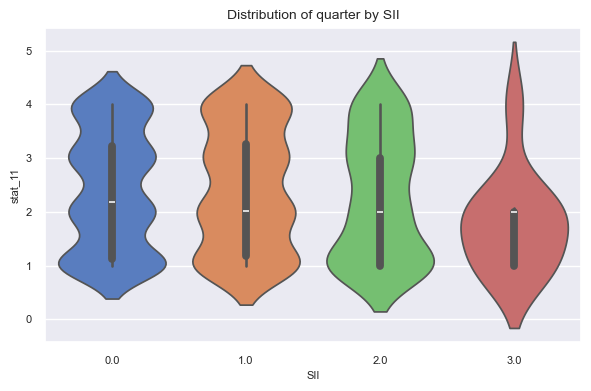

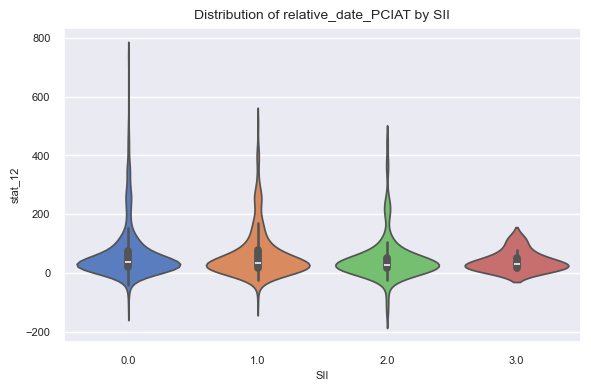

In [71]:
#Correlation map of all accelometer features with the target variable.........
#TO map the correlation, the data from csv files and parquet files are merged and crerated a dataframe.
df_parquet = None
dir_name = 'child-mind-institute-problematic-internet-use/'
    
df_parquet = read_parquet_file_corr(os.path.join(dir_name,'series_train.parquet/'))
df_parquet_merged = pd.merge(train, df_parquet, how="inner", on='id')
#df_parquet_merged
# Notes: All the participant with the unique id does not have accelometer data, there are 3960 rows in the 
# train.csv while there are only 996 parquet files. So each participant does not have accelometer data.
#The following dataframe compromises all the features including the demographical and accelometer features on for
#the 996 participants.

# Lets visualize the relationship between accelometer data and the target variable.
df_temp = None
df_temp = df_parquet_merged.loc[:, df_parquet_merged.columns.str.contains('stat')]
df_temp['sii'] = df_parquet_merged['sii']
df_temp = df_temp.groupby('sii')[['stat_0','stat_1','stat_2','stat_3'
,'stat_4','stat_5','stat_6','stat_7','stat_8','stat_9','stat_10'
,'stat_11','stat_12'
 ]]

stat_features = ['stat_0', 'stat_1', 'stat_2', 'stat_3', 'stat_4',
                 'stat_5', 'stat_6', 'stat_7', 'stat_8', 'stat_9',
                 'stat_10', 'stat_11', 'stat_12']

real_feature_names = ['step','X','Y','Z','enmo','anglez','non-wear_flag','light','battery_voltage','time_of_day'
,'weekday','quarter','relative_date_PCIAT']

i = 0
for feature in stat_features:
    plt.figure(figsize=(6, 4))  # Reduced figure size
    sns.violinplot(data=df_parquet_merged, x='sii', y=feature, palette='muted')
    real_feature = real_feature_names[i]
    i = i + 1
    # Update font sizes
    plt.title(f'Distribution of {real_feature} by SII', fontsize=10)
    plt.xlabel('SII', fontsize=8)
    plt.ylabel(feature, fontsize=8)
    
    # Reduce tick label size
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    
    plt.tight_layout()
    plt.show()

In [72]:
def prepare_merged_df(dir_name, df_train, df_test):
    
    train = df_train
    test = df_test


    train_ts = read_parquet_file(os.path.join(dir_name,'series_train.parquet/'))
    test_ts = read_parquet_file(os.path.join(dir_name,'series_train.parquet/'))
    


    df_train = train_ts.drop('id', axis=1)
    df_test = test_ts.drop('id', axis=1)


    train_ts_encoded = perform_autoencoder(df_train, encoding_dim=20, epochs=100, batch_size=32)
    test_ts_encoded = perform_autoencoder(df_test, encoding_dim=20, epochs=100, batch_size=32)
    



    train_ts_encoded["id"]=train_ts["id"]
    test_ts_encoded['id']=test_ts["id"]

    train = pd.merge(train, train_ts_encoded, how="left", on='id')
    test = pd.merge(test, test_ts_encoded, how="left", on='id')

    return train


In [73]:
# Now impute the null values
def imputer_df(df):
    
    train = df
    imputer = KNNImputer(n_neighbors=5)


    numeric_cols = train.select_dtypes(include=['float32', 'float64', 'int64']).columns
    

    imputed_data = imputer.fit_transform(train[numeric_cols])
    train_imputed = pd.DataFrame(imputed_data, columns=numeric_cols, index=train.index)
    #train_imputed['sii'] = train_imputed['sii'].round().astype(int)
    for col in train.columns:
        if col not in numeric_cols:
 
            train_imputed[col] = train[col]

        
    train = train_imputed
    #train = feature_engineering(train)
    #train = train.dropna(thresh=10, axis=0)
    #test = feature_engineering(test)

    return train


In [74]:
def display_dataset_info(dataset, name):  
    print("-----------------------------------------------------------------")  
    print(f"{name} DataFrame Shape: Rows = {dataset.shape[0]}, Columns = {dataset.shape[1]}")  
   
    print(f"{name} DataFrame numeric columns size = {len(dataset.select_dtypes('number').columns)}, categorical columns size = {dataset.shape[1]}")
    total_missing = dataset.isnull().sum().sum()  
    if total_missing > 0:  
        print(f"There are a total of {total_missing} missing values in the {name} DataFrame.")  
    else:  
        print(f"There are no missing values in the {name} DataFrame.")  

    total_duplicates = dataset.duplicated().sum()  
    if total_duplicates > 0:  
        print(f"There are {total_duplicates} duplicate rows in the {name} DataFrame.")  
    else:  
        print(f"There are no duplicate rows in the {name} DataFrame.")  

    print("-----------------------------------------------------------------") 

In [75]:
def plot_visualization(classifiers, accuracy, mses):

    # Create a DataFrame
    results_df = pd.DataFrame({
    'Model': classifiers,
    'Accuracy': accuracy,
    'Mean Squared Error': mses
        })

    # Step 2: Create a figure with two subplots for Accuracy and Mean Squared Error
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))
    sns.set(font_scale=1.5)
    # Plot Accuracy
    sns.barplot(x='Accuracy', y='Model', data=results_df, ax=ax[0], palette='viridis')
    ax[0].set_title('Accuracy of Different Models')
    ax[0].set_xlim(0, 1)  # Set x-axis limit to 0-1 for accuracy
    ax[0].set_xlabel('Accuracy')

# Plot Mean Squared Error
    sns.barplot(x='Mean Squared Error', y='Model', data=results_df, ax=ax[1], palette='coolwarm')
    ax[1].set_title('Mean Squared Error of Different Models')
    ax[1].set_xlabel('Mean Squared Error')

    # Add value labels on top of the bars
    for i in ax[0].patches:
        ax[0].annotate(f'{i.get_width():.2f}', 
                   (i.get_width() + 0.01, i.get_y() + i.get_height() / 2), 
                   xytext=(5, 0), textcoords='offset points', 
                   ha='center', va='center')

    for i in ax[1].patches:
        ax[1].annotate(f'{i.get_width():.2f}', 
                   (i.get_width() + 0.01, i.get_y() + i.get_height() / 2), 
                   xytext=(5, 0), textcoords='offset points', 
                   ha='center', va='center')

    # Step 3: Adjust layout for better readability
    plt.tight_layout()

    # Show the plot
    plt.show()

    
    

In [76]:
def perform_model(df):
    
    score_list = []
    mse_list = []
    class_name = []
    df_new = df.copy()
    
    
    #df_new = df_new.drop('id', axis=1)
    
    
    # Drop rows with NaN or inf values in both physical and neural network features
    df_temp = df_new[~df_new.isna().any(axis=1)]
    
    
    df_new = df_temp[~np.isinf(df_temp).any(axis=1)]
    
    
    X = df_new.drop(columns='sii', axis =1)
    y = df_new['sii']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    # Initialize and train the HistGradientBoostingClassifier
    hgb_classifier = HistGradientBoostingClassifier(random_state=42)
    hgb_classifier.fit(X_train, y_train)  # X_train can contain NaNs
    
    # Predict on the test set
    y_pred_hgb = hgb_classifier.predict(X_test)

    # Evaluate the model
    accuracy_hgb = accuracy_score(y_test, y_pred_hgb)
    print(f'Accuracy (HistGradientBoosting): {accuracy_hgb}')
    
    # Calculate Mean Squared Error
    mse = mean_squared_error(y_test, y_pred_hgb)

    print(f"Mean Squared Error (HistGradientBoosting): {mse}")
    # Evaluate the model
    #accuracy = accuracy_score(y_test, y_pred)
    
    class_name.append('HistGradientBoosting')
    score_list.append(accuracy_hgb)
    mse_list.append(mse)

    
    knn = KNeighborsClassifier(n_neighbors=5)

    # Train the KNN model
    knn.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = knn.predict(X_test)

    # Evaluate the model using accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy of KNN classifier: {accuracy:.4f}')
    
    # Calculate Mean Squared Error
    mse = mean_squared_error(y_test, y_pred)

    print(f"Mean Squared Error of KNN classifier: {mse}")
    #
    class_name.append('KNN classifier')
    score_list.append(accuracy)
    mse_list.append(mse)
 
    
    # Initialize and train the Logistic Regression model
    log_reg = LogisticRegression(max_iter=3000, random_state=42)  # Increase max_iter if necessary for convergence
    log_reg.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = log_reg.predict(X_test)

    # Evaluate the model using accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy of Logistic Regression: {accuracy:.4f}")
    # Calculate Mean Squared Error
    mse = mean_squared_error(y_test, y_pred)

    print(f"Mean Squared Error Logistic Regression: {mse}")
    
    class_name.append('Logistic Regression')
    score_list.append(accuracy)
    mse_list.append(mse)

    
    # Initialize and train the SVM classifier (using RBF kernel by default)
    svm_model = SVC(random_state=42)
    svm_model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = svm_model.predict(X_test)

    # Evaluate the model using accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy of SVM classifier: {accuracy:.4f}")

    # Calculate Mean Squared Error
    mse = mean_squared_error(y_test, y_pred)

    print(f"Mean Squared Error of SVM classifier: {mse}")
    class_name.append('SVM classifier')
    score_list.append(accuracy)
    mse_list.append(mse)

    
    decision_tree = DecisionTreeClassifier(random_state=42, max_depth=10)
    decision_tree.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = decision_tree.predict(X_test)

    # Evaluate the model using accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy of Decision Tree classifier: {accuracy:.4f}")
    
    
        # Calculate Mean Squared Error
    mse = mean_squared_error(y_test, y_pred)

    print(f"Mean Squared Error of Decision Tree classifier: {mse}")
    class_name.append('Decision Tree classifier')
    score_list.append(accuracy)
    mse_list.append(mse)


    # Initialize and train the Random Forest classifier
    random_forest = RandomForestClassifier(random_state=42)
    random_forest.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = random_forest.predict(X_test)

    # Evaluate the model using accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy of Random Forest classifier: {accuracy:.4f}")
    
        # Calculate Mean Squared Error
    mse = mean_squared_error(y_test, y_pred)

    print(f"Mean Squared Error of Random Forest classifier: {mse}")
    class_name.append('Random Forest classifier')
    score_list.append(accuracy)
    mse_list.append(mse)


    print(df_new.info())
    
    plot_visualization(class_name, score_list, mse_list)

    

In [77]:
# its time to train the model by splitting the data.
def train_model(dir_name):
    
    train = pd.read_csv(os.path.join(dir_name,'train.csv'))
    test = pd.read_csv(os.path.join(dir_name,'test.csv'))
    
    #train = train.dropna(subset=['sii'], axis=0)
    df = None
    
    df = prepare_merged_df(dir_name, train, test)

    df = imputer_df(df)
    display_dataset_info(df, 'train')
    
    # Finally devide the data and implement the model
    
    perform_model(df)

    return df
    

In [78]:
#Based on the above analysis, features that FCG features can be dropped easily. All the seasonal features does
# not have any contribution towards the target variable as they only represents the season in which the particpant
#either enrolled or bieng tested.

## First Model:
    The first model is performed by calculating the correlation matrix and use that correlation to discard the
    features below a certain threshhold.
Steps Performed:
    1 : Transformed the data using one-hot-encoder.
    2 : Megred the encoded data and the numerical features to compile a dataframe.
    3 : Calculated the correlation matrix with the target variable.
    4 : Drop all the features that has either positive correlation less than 0.3 or -0.3.
    5 : Drop all the nan or infinity values.
    6 : Perform the multiple models.

Accuracy (HistGradientBoosting): 1.0
Mean Squared Error (HistGradientBoosting): 0.0
Accuracy of KNN classifier: 0.9668
Mean Squared Error of KNN classifier: 0.03319502074688797
Accuracy of Logistic Regression: 0.9876
Mean Squared Error Logistic Regression: 0.012448132780082987
Accuracy of SVM classifier: 0.9772
Mean Squared Error of SVM classifier: 0.022821576763485476
Accuracy of Decision Tree classifier: 1.0000
Mean Squared Error of Decision Tree classifier: 0.0
Accuracy of Random Forest classifier: 0.9959
Mean Squared Error of Random Forest classifier: 0.004149377593360996
<class 'pandas.core.frame.DataFrame'>
Index: 2406 entries, 00008ff9 to ffed1dd5
Data columns (total 26 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Basic_Demos-Age                         2406 non-null   int64  
 1   Physical-Height                         2406 non-null   float64
 2   Physical-Weight        

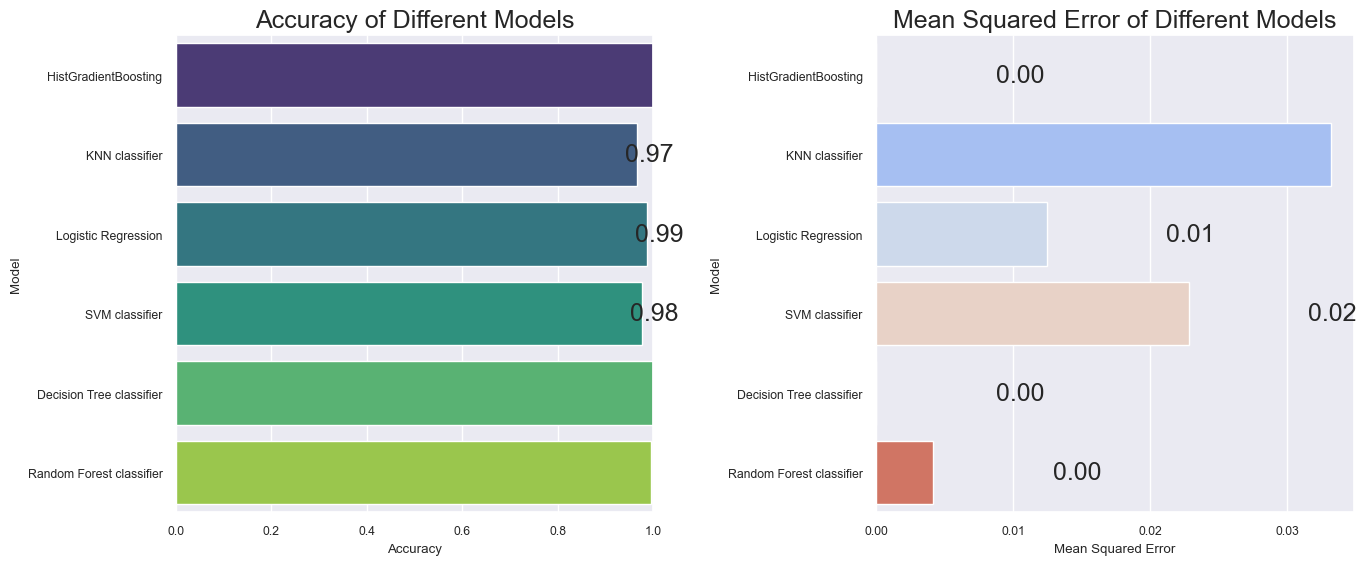

In [79]:
# The following model implemented by choisng the features that has high correlation with the target value.
# No parquet features are attached.
df_temp = None
encoder = OneHotEncoder(sparse=False)

df = train.copy()
df_temp = df.set_index('id', drop=True)

df = None
obj_col = list(df_temp.select_dtypes('object'))
obj_col.remove('sii')
df = df_temp.loc[:, obj_col]

encoded = encoder.fit_transform(df)
encoded_df = pd.DataFrame(encoded, index = df_temp.index, columns=encoder.get_feature_names_out(obj_col))

df = None
df = df_temp.drop(obj_col, axis = 1)
df_final = pd.concat([df, encoded_df], axis=1)
corr_arr = df_final.corr()['sii']
col_list = []
for i, corr in enumerate(corr_arr):
    if (corr > 0.3):
        
        col_list.append(corr_arr.index[i])
    elif (corr < -0.3):
        
        col_list.append(corr_arr.index[i])

df_model = df_final.loc[:, col_list]
df_model

df_model.replace([np.inf, -np.inf], np.nan, inplace=True)  # Replace inf values with NaN if necessary
perform_model(df_model)

# The model performed pretty well with 2406 rows. Nan values are just dropped. No parquet features are attached.  


## Second Model:
    The second model is performed after merging the data from parquet and csv files.
Steps perfromed:
    1 : Merge the data from parquet and csv files and created a dataframe.
    2 : Check the null acount and drop the column if the count of null value is greater than 60%
    3 : Drop all the columns with the season word in its name
    4 : Change the data type of the follwonig features: 
    BIA-BIA_Activity_Level_num
    PreInt_EduHx-computerinternet_hoursday
    5 : Drop the outliers
    6 : Impute the null values
    7 : Drop the infinity values
    8 : Train and filt the model
    9 : Record the results
    

-----------------------------------------------------------------
train DataFrame Shape: Rows = 228, Columns = 74
train DataFrame numeric columns size = 73, categorical columns size = 74
There are no missing values in the train DataFrame.
There are no duplicate rows in the train DataFrame.
-----------------------------------------------------------------
Accuracy (HistGradientBoosting): 0.9782608695652174
Mean Squared Error (HistGradientBoosting): 0.021739130434782608
Accuracy of KNN classifier: 0.7391
Mean Squared Error of KNN classifier: 0.32608695652173914
Accuracy of Logistic Regression: 0.7391
Mean Squared Error Logistic Regression: 0.32608695652173914
Accuracy of SVM classifier: 0.7391
Mean Squared Error of SVM classifier: 0.32608695652173914
Accuracy of Decision Tree classifier: 1.0000
Mean Squared Error of Decision Tree classifier: 0.0
Accuracy of Random Forest classifier: 0.9348
Mean Squared Error of Random Forest classifier: 0.06521739130434782
<class 'pandas.core.frame.DataF

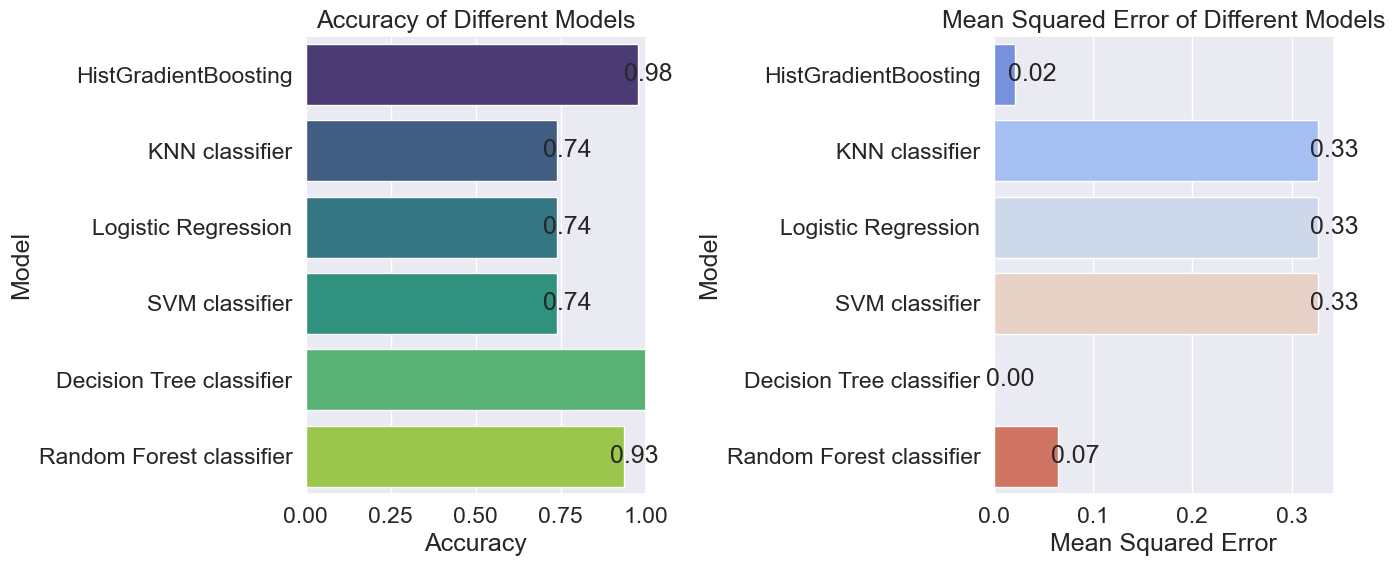

In [80]:
df_parquet = None
dir_name = 'child-mind-institute-problematic-internet-use/'
df_parquet = read_parquet_file_corr(os.path.join(dir_name,'series_train.parquet/'))
df_parquet_merged = pd.merge(train, df_parquet, how="inner", on='id')


arr = df_parquet_merged.isnull().sum()
    
col_list = []
df_len = len(df_parquet_merged)
for i in range(0, len(arr)):
    if arr[i] >= (df_len * 0.6):
        col_list.append(arr.index[i])

df_parquet_merged = df_parquet_merged.drop(col_list, axis=1)    
col_drop_list = [col for col in df_parquet_merged.columns if 'Season' in col]
df_parquet_merged = df_parquet_merged.drop(col_drop_list, axis=1)


    
#Upon investigating, object column has values that easily be converted into numerical form. So lets convert the object
#type to numerical form.

df_parquet_merged['BIA-BIA_Activity_Level_num'] = pd.to_numeric(df_parquet_merged['BIA-BIA_Activity_Level_num'])
df_parquet_merged['PreInt_EduHx-computerinternet_hoursday'] = pd.to_numeric(df_parquet_merged['PreInt_EduHx-computerinternet_hoursday'])

df_parquet_merged = df_parquet_merged.set_index('id')
df_parquet_merged

# Calculate the IQR for each numerical column
Q1 = df_parquet_merged.quantile(0.25)
Q3 = df_parquet_merged.quantile(0.75)
IQR = Q3 - Q1

# Define outlier bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers
df_no_outliers = df_parquet_merged[~((df_parquet_merged < lower_bound) | (df_parquet_merged > upper_bound)).any(axis=1)]
""""
arr = df_no_outliers.isnull().sum()
for i in range(0, len(arr)):
    print(arr.index[i], arr[i])
"""

df = imputer_df(df_no_outliers)
display_dataset_info(df, 'train')
df.replace([np.inf, -np.inf], np.nan, inplace=True) 
perform_model(df)





## Third Model:
    The third model is like the second model with the following two differences:
        1 : Outliers are not dropped
        2 : Data is scaled through standard scaler before training the model
        

-----------------------------------------------------------------
train DataFrame Shape: Rows = 996, Columns = 74
train DataFrame numeric columns size = 73, categorical columns size = 74
There are no missing values in the train DataFrame.
There are no duplicate rows in the train DataFrame.
-----------------------------------------------------------------
Accuracy (HistGradientBoosting): 0.99
Mean Squared Error (HistGradientBoosting): 0.01
Accuracy of KNN classifier: 0.8450
Mean Squared Error of KNN classifier: 0.155
Accuracy of Logistic Regression: 0.9300
Mean Squared Error Logistic Regression: 0.07
Accuracy of SVM classifier: 0.9400
Mean Squared Error of SVM classifier: 0.06
Accuracy of Decision Tree classifier: 1.0000
Mean Squared Error of Decision Tree classifier: 0.0
Accuracy of Random Forest classifier: 0.9900
Mean Squared Error of Random Forest classifier: 0.01
<class 'pandas.core.frame.DataFrame'>
Index: 996 entries, 00115b9f to ffed1dd5
Data columns (total 74 columns):
 #   Col

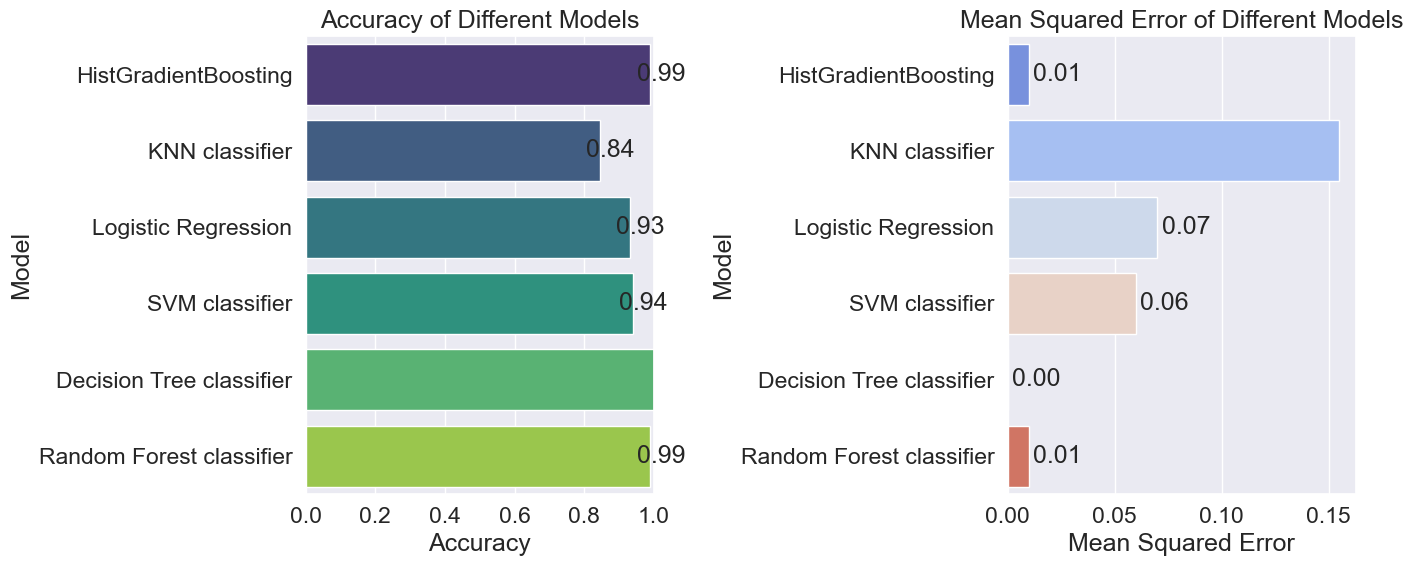

In [81]:
df_parquet_scaled = None
dir_name = 'child-mind-institute-problematic-internet-use/'
df_parquet_scaled = read_parquet_file_corr(os.path.join(dir_name,'series_train.parquet/'))
df_parquet_scaled_merged = pd.merge(train, df_parquet, how="inner", on='id')

arr = df_parquet_scaled_merged.isnull().sum()

    
col_list = []
df_len = len(df_parquet_scaled_merged)
for i in range(0, len(arr)):
    if arr[i] >= (df_len * 0.6):
        col_list.append(arr.index[i])

df_parquet_scaled_merged = df_parquet_scaled_merged.drop(col_list, axis=1)    
col_drop_list = [col for col in df_parquet_scaled_merged.columns if 'Season' in col]
df_parquet_scaled_merged = df_parquet_scaled_merged.drop(col_drop_list, axis=1)

    
#Upon investigating, object column has values that easily be converted into numerical form. So lets convert the object
#type to numerical form.

df_parquet_scaled_merged['BIA-BIA_Activity_Level_num'] = pd.to_numeric(df_parquet_scaled_merged['BIA-BIA_Activity_Level_num'])
df_parquet_scaled_merged['PreInt_EduHx-computerinternet_hoursday'] = pd.to_numeric(df_parquet_scaled_merged['PreInt_EduHx-computerinternet_hoursday'])

df_parquet_scaled_merged = df_parquet_scaled_merged.set_index('id')


scaled = StandardScaler()
target_col = df_parquet_scaled_merged['sii']
df_parquet_scaled_merged = df_parquet_scaled_merged.drop('sii', axis=1)

df_parquet_scaled_merged = pd.DataFrame(scaled.fit_transform(df_parquet_scaled_merged), columns=df_parquet_scaled_merged.columns, index=df_parquet_scaled_merged.index)
df_parquet_scaled_merged['sii'] = target_col

df = imputer_df(df_parquet_scaled_merged)
display_dataset_info(df, 'train')
df.replace([np.inf, -np.inf], np.nan, inplace=True) 
perform_model(df)


## Fourth Model:
    The model is trained using PCA componets. The merged dataframe is traing using only two PCA componets instead
    of keeping all the features. Still the accuracy score is satisfied.

Accuracy of Logistic regression: 0.95
Accuracy of Decision Tree: 0.89
Accuracy of Random Forest: 0.94


<Axes: >

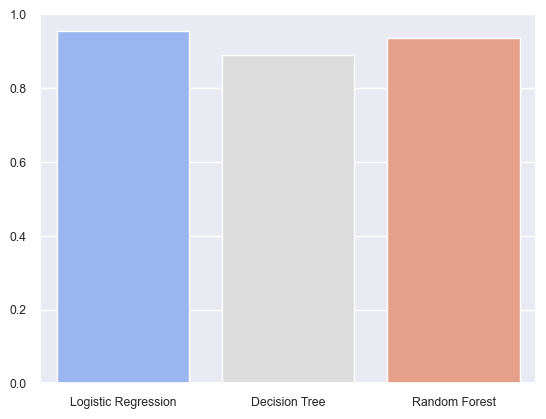

In [82]:
score_list = []

class_name = []


df_parquet = None
dir_name = 'child-mind-institute-problematic-internet-use/'
df_parquet = read_parquet_file_corr(os.path.join(dir_name,'series_train.parquet/'))
df_parquet_merged = pd.merge(train, df_parquet, how="inner", on='id')
df_parquet_merged['BIA-BIA_Activity_Level_num'] = pd.to_numeric(df_parquet_merged['BIA-BIA_Activity_Level_num'])
df_parquet_merged['sii'] = df_parquet_merged['sii'].replace({0.0 : 'None', 1.0 : 'Mild', 2.0 : 'Moderate', 3.0 : 'Severe'})

df_parquet_merged = df_parquet_merged.set_index('id')


X = df_parquet_merged.drop('sii', axis=1)  # Features
y = df_parquet_merged['sii']  # Target

# Define categorical and numerical columns
categorical_cols = X.select_dtypes('object').columns.to_list()
numerical_cols = X.select_dtypes(exclude='object').columns.to_list()

### Create a ColumnTransformer with Imputer, OneHotEncoder for categorical features, and StandardScaler for numerical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values in numerical columns (mean imputation)
            ('scaler', StandardScaler())                  # Apply StandardScaler to numerical columns
        ]), numerical_cols),
        
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),  # Impute missing values in categorical columns
            ('onehot', OneHotEncoder())  # Apply OneHotEncoder to categorical columns
        ]), categorical_cols)
    ])

# Create a pipeline with preprocessor, PCA, and a classification model
pipeline1 = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Preprocessing (Imputation + Scaling + Encoding)
    ('pca', PCA(n_components=2)),    # PCA for dimensionality reduction
    ('classifier', LogisticRegression())  # Classification model (Logistic Regression)
])

# Create a pipeline with preprocessor, PCA, and a classification model
pipeline2 = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Preprocessing (Imputation + Scaling + Encoding)
    ('pca', PCA(n_components=2)),    # PCA for dimensionality reduction
    ('classifier', DecisionTreeClassifier(random_state=42, max_depth=10))  # Classification model (Logistic Regression)
])

# Create a pipeline with preprocessor, PCA, and a classification model
pipeline3 = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Preprocessing (Imputation + Scaling + Encoding)
    ('pca', PCA(n_components=2)),    # PCA for dimensionality reduction
    ('classifier', RandomForestClassifier(random_state=42))  # Classification model (Logistic Regression)
])
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Fit the pipeline on the training data
pipeline1.fit(X_train, y_train)

# Predict on the test set
y_pred = pipeline1.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy of Logistic regression: {accuracy:.2f}')
    # Calculate Mean Squared Error

class_name.append('Logistic Regression')
score_list.append(accuracy)



# Fit the pipeline on the training data
pipeline2.fit(X_train, y_train)

# Predict on the test set
y_pred = pipeline2.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy of Decision Tree: {accuracy:.2f}')

class_name.append('Decision Tree')
score_list.append(accuracy)



# Fit the pipeline on the training data
pipeline3.fit(X_train, y_train)

# Predict on the test set
y_pred = pipeline3.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy of Random Forest: {accuracy:.2f}')


class_name.append('Random Forest')

score_list.append(accuracy)

# Plot Mean Squared Error
sns.set(font_scale=0.8)
sns.barplot(x=class_name, y=score_list,  palette='coolwarm')




## Fifth Model:
    The very last model implemented on both types of data and performed PCA and manual feature removal to
    reduce the dimension of the data.
Steps Performed: 1 : Reduce the dimentionalty of the accelometer data to 3 features instead of 13.
                 2 : Merged the data from parquet and csv files.
                 3 : Removed the null values for the target column.
                 4 : Create the mapping for null values.
                 5 : Impute the missing values and encoded the fatures thorugh onehotencoder and standard scale
                    implemented thorugh pipeline.
                 6 : Fit and train the model.
                 7 : Predict and visualize the accuracy socre.

In [83]:

def bp_category(row):
    if row['Physical-Systolic_BP'] < 120 and row['Physical-Diastolic_BP'] < 80:
        return 'Normal'
    elif (120 <= row['Physical-Systolic_BP'] < 140) or (80 <= row['Physical-Diastolic_BP'] < 90):
        return 'Prehypertension'
    else:
        return 'Hypertension'



def feature_engineering(df):
    season_cols = [col for col in df.columns if 'Season' in col]
    df = df.drop(season_cols, axis=1)
    pciat_cols = [col for col in df.columns if 'PCIAT' in col]
    pciat_cols.remove('PCIAT-PCIAT_Total')
    pciat_cols
    df['BP_Category'] = df.apply(bp_category, axis=1)
    return df

"""

    #df = df.drop(pciat_cols, axis=1)
    df['BMI_Age'] = df['Physical-BMI'] * df['Basic_Demos-Age']
    df['Internet_Hours_Age'] = df['PreInt_EduHx-computerinternet_hoursday'] * df['Basic_Demos-Age']
    df['BMI_Internet_Hours'] = df['Physical-BMI'] * df['PreInt_EduHx-computerinternet_hoursday']
    df['BFP_BMI'] = df['BIA-BIA_Fat'] / df['BIA-BIA_BMI']
    df['FFMI_BFP'] = df['BIA-BIA_FFMI'] / df['BIA-BIA_Fat']
    df['FMI_BFP'] = df['BIA-BIA_FMI'] / df['BIA-BIA_Fat']
    df['LST_TBW'] = df['BIA-BIA_LST'] / df['BIA-BIA_TBW']
    df['BFP_BMR'] = df['BIA-BIA_Fat'] * df['BIA-BIA_BMR']
    df['BFP_DEE'] = df['BIA-BIA_Fat'] * df['BIA-BIA_DEE']
    df['BMR_Weight'] = df['BIA-BIA_BMR'] / df['Physical-Weight']
    df['DEE_Weight'] = df['BIA-BIA_DEE'] / df['Physical-Weight']
    df['SMM_Height'] = df['BIA-BIA_SMM'] / df['Physical-Height']
    df['Muscle_to_Fat'] = df['BIA-BIA_SMM'] / df['BIA-BIA_FMI']
    df['Hydration_Status'] = df['BIA-BIA_TBW'] / df['Physical-Weight']
    df['ICW_TBW'] = df['BIA-BIA_ICW'] / df['BIA-BIA_TBW']
    
"""
    

def feature_engineering_parquet(df):

    df_new = df[['X', 'Y', 'Z', 'anglez', 'enmo']]
    df_new['acc_magnitude'] = np.sqrt(np.square(df_new['X']) + np.square(df_new['Y']) + np.square(df_new['Z']))
    df_new = df_new[['acc_magnitude', 'anglez', 'enmo']]
    return df_new



def process_parquet_files(file_name, dir_name):


    df = pd.read_parquet(os.path.join(dir_name, file_name, 'part-0.parquet'))
    df = feature_engineering_parquet(df)   

    return df.mean().values.reshape(-1), file_name.split('=')[1]

def read_parquet_file(dir_name):

    files_list = os.listdir(dir_name)
    #files_list = ['id=0a418b57', 'id=0a431608']
    for file in files_list:
        if file == '.DS_Store':
            files_list.remove('.DS_Store')
    with ThreadPoolExecutor() as executor:
        results = list(executor.map(lambda fname: process_parquet_files(fname, dir_name), files_list))

        
    stats, indexes = zip(*results)
    df = pd.DataFrame(stats, columns=[f"stat_{i}" for i in range(len(stats[0]))])
    df['id'] = indexes
    return df
    


def update(df, col_list):

    for c in col_list: 
        df[c] = df[c].fillna('Missing')
        df[c] = df[c].astype('category')
    return df

def create_mapping(column, dataset):
    unique_values = dataset[column].unique()
    return {value: idx for idx, value in enumerate(unique_values)}

def draw_confusion_matrix(pipeline1, pipeline2, pipeline3, X_test, y_test):


    # Get predictions from each model
    y_pred_lr = pipeline1.predict(X_test)
    y_pred_dt = pipeline2.predict(X_test)
    y_pred_rf = pipeline3.predict(X_test)

    # Compute the confusion matrices for each model
    cm_lr = confusion_matrix(y_test, y_pred_lr)
    cm_dt = confusion_matrix(y_test, y_pred_dt)
    cm_rf = confusion_matrix(y_test, y_pred_rf)
    classes = np.unique(y_test)
    # Plot the confusion matrices
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Plot for Logistic Regression
    sns.heatmap(cm_lr, annot=True, fmt="d", cmap="Blues", ax=axes[0], cbar=False)
    axes[0].set_title('Logistic Regression Confusion Matrix')
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('Actual')
    axes[0].set_xticklabels(classes)
    axes[0].set_yticklabels(classes)

    # Plot for Decision Tree
    sns.heatmap(cm_dt, annot=True, fmt="d", cmap="Blues", ax=axes[1], cbar=False)
    axes[1].set_title('Decision Tree Confusion Matrix')
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('Actual')
    axes[1].set_xticklabels(classes)
    axes[1].set_yticklabels(classes)

    # Plot for Random Forest
    sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues", ax=axes[2], cbar=False)
    axes[2].set_title('Random Forest Confusion Matrix')
    axes[2].set_xlabel('Predicted')
    axes[2].set_ylabel('Actual')
    axes[2].set_xticklabels(classes)
    axes[2].set_yticklabels(classes)

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()


-----------------------------------------------------------------
train DataFrame Shape: Rows = 2736, Columns = 58
train DataFrame numeric columns size = 56, categorical columns size = 58
There are a total of 36850 missing values in the train DataFrame.
There are no duplicate rows in the train DataFrame.
-----------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Index: 2736 entries, 00008ff9 to ffed1dd5
Data columns (total 58 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Basic_Demos-Age                         2736 non-null   int64  
 1   Basic_Demos-Sex                         2736 non-null   int64  
 2   CGAS-CGAS_Score                         2342 non-null   float64
 3   Physical-BMI                            2527 non-null   float64
 4   Physical-Waist_Circumference            483 non-null    float64
 5   Physical-Diastolic_BP      

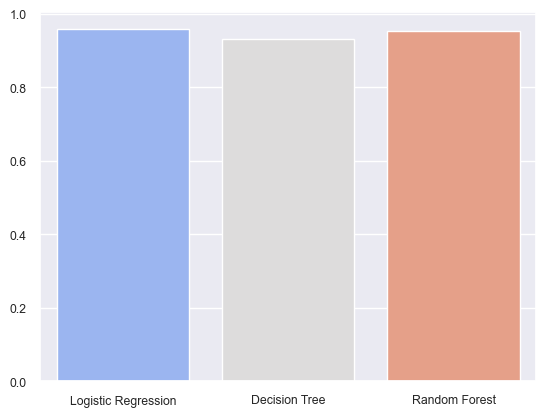

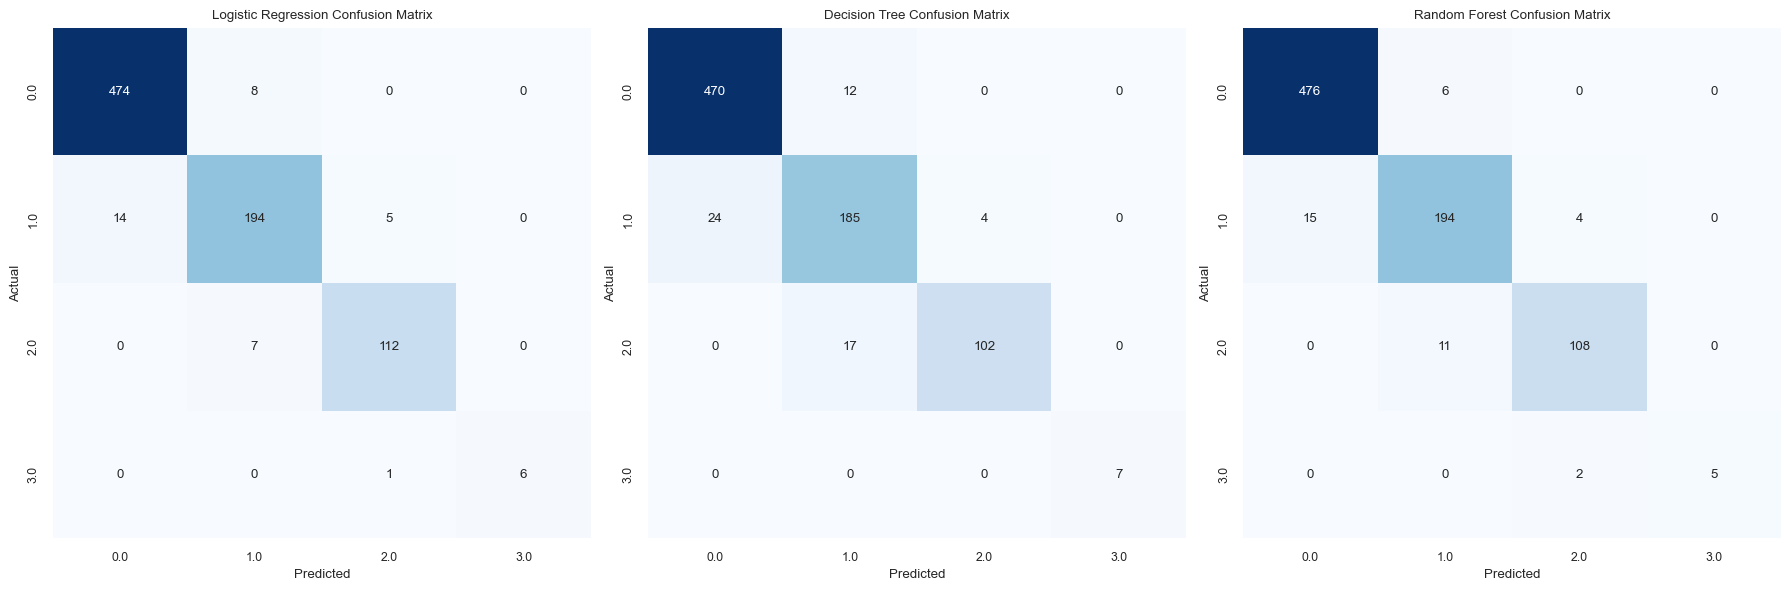

In [84]:
class_name = []
score_list = []

df_parquet = None
dir_name = 'child-mind-institute-problematic-internet-use/'
df_parquet = read_parquet_file(os.path.join(dir_name,'series_train.parquet/'))
df_parquet_merged = pd.merge(train, df_parquet, how="left", on='id')
df = df_parquet_merged.dropna(subset='sii')
df['BIA-BIA_Activity_Level_num'] = pd.to_numeric(df['BIA-BIA_Activity_Level_num'])
df['sii'] = df['sii'].astype('object')
col_list = [col for col in df.columns if 'Season' in col]

df = update(df, col_list)

for col in col_list:
    mapping = create_mapping(col, df)
    
    df[col] = df[col].replace(mapping).astype(int)

df = feature_engineering(df)

features_to_drop = ['Physical-Height', 'Physical-Weight', 'BIA-BIA_BMC', 'BIA-BIA_BMI', 'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW',
                    'BIA-BIA_FFM', 'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_ICW',
                    'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM', 'BIA-BIA_TBW']


df = df.drop(features_to_drop, axis=1)
df = df.set_index('id')
display_dataset_info(df, 'train')
df.info()
df.replace([np.inf, -np.inf], np.nan, inplace=True)

X = None
y = None
X = df.drop('sii', axis=1)  # Features
y = df['sii']  # Target


# Define categorical and numerical columns
categorical_cols = X.select_dtypes('object').columns.to_list()
numerical_cols = X.select_dtypes(exclude='object').columns.to_list()



### Create a ColumnTransformer with Imputer, OneHotEncoder for categorical features, and StandardScaler for numerical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values in numerical columns (mean imputation)
            ('scaler', StandardScaler())                  # Apply StandardScaler to numerical columns
        ]), numerical_cols),
        
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),  # Impute missing values in categorical columns
            ('onehot', OneHotEncoder())  # Apply OneHotEncoder to categorical columns
        ]), categorical_cols)
    ])


# Create a pipeline with preprocessor, PCA, and a classification model
pipeline1 = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Preprocessing (Imputation + Scaling + Encoding)
    ('pca', PCA(n_components=5)),    # PCA for dimensionality reduction
    ('classifier', LogisticRegression())  # Classification model (Logistic Regression)
])


# Create a pipeline with preprocessor, PCA, and a classification model
pipeline2 = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Preprocessing (Imputation + Scaling + Encoding)
    ('pca', PCA(n_components=5)),    # PCA for dimensionality reduction
    ('classifier', DecisionTreeClassifier(random_state=42, max_depth=10))  # Classification model (Logistic Regression)
])

# Create a pipeline with preprocessor, PCA, and a classification model
pipeline3 = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Preprocessing (Imputation + Scaling + Encoding)
    ('pca', PCA(n_components=5)),    # PCA for dimensionality reduction
    ('classifier', RandomForestClassifier(random_state=42))  # Classification model (Logistic Regression)
])

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=24)

# Fit the pipeline on the training data
pipeline1.fit(X_train, y_train)

# Predict on the test set
y_pred = pipeline1.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy of Logistic regression: {accuracy:.2f}')
    # Calculate Mean Squared Error

class_name.append('Logistic Regression')
score_list.append(accuracy)



# Fit the pipeline on the training data
pipeline2.fit(X_train, y_train)

# Predict on the test set
y_pred = pipeline2.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy of Decision Tree: {accuracy:.2f}')

class_name.append('Decision Tree')
score_list.append(accuracy)



# Fit the pipeline on the training data
pipeline3.fit(X_train, y_train)

# Predict on the test set
y_pred = pipeline3.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy of Random Forest: {accuracy:.2f}')


class_name.append('Random Forest')

score_list.append(accuracy)

# Plot Mean Squared Error
sns.set(font_scale=0.8)
sns.barplot(x=class_name, y=score_list,  palette='coolwarm')
draw_confusion_matrix(pipeline1, pipeline2, pipeline3, X_test, y_test)

